<a href="https://colab.research.google.com/github/RodionHorbunov/Convolutional-Neural-Networks-and-Image-Classification-Muffin-vs-Chihuahua-/blob/main/Rodion_Horbunov_Neural_Networks_project_(matriculation_988092).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [ ]:
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
import zipfile
import matplotlib.pyplot as plt
import pickle
import statistics as st
from PIL import Image


##Download and Inspect the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

drive_path = '/content/drive/MyDrive/Muffin vs chihuahua'
directory = os.listdir(drive_path)

for item in directory:
    print(item)

MaffinsVsChihuahua.zip


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Muffin vs chihuahua/MaffinsVsChihuahua.zip', 'r') # Open the zip file containing all the images
zip_ref.extractall('/Muffin vs chihuahua') # Extract the file in /Muffin vs chihuahua folder
zip_ref.close()

Extract it to the current directory.

In [ ]:
print("Muffins photos at train folder :" +str(len(os.listdir('./../Muffin vs chihuahua/train/muffin'))))
print("Chihuahua photos at train folder :" +str(len(os.listdir('./../Muffin vs chihuahua/train/chihuahua'))))

Muffins photos at train folder :2174
Chihuahua photos at train folder :2559


In [ ]:
print("Muffins photos at test folder :" +str(len(os.listdir('./../Muffin vs chihuahua/test/muffin'))))
print("Chihuahua photos at test folder :" +str(len(os.listdir('./../Muffin vs chihuahua/test/chihuahua'))))

Muffins photos at test folder :544
Chihuahua photos at test folder :640


In [ ]:
print("Chihuahua photoes - :",2559+640)
print("Muffins  photoes - :",2174+544)


Chihuahua photoes - : 3199
Muffins  photoes - : 2718



## Transforming images and taking the sample from the dataset

The contents of the .zip are extracted to the base directory

In [ ]:
import os


print("Contents of base directory:")
print(os.listdir('./../Muffin vs chihuahua'))

print("\nContents of train directory:")
print(os.listdir('./../Muffin vs chihuahua/train'))

print("\nContents of validation directory:")
print(os.listdir('./../Muffin vs chihuahua/test'))

Contents of base directory:
['train', 'test']

Contents of train directory:
['muffin', 'chihuahua']

Contents of validation directory:
['muffin', 'chihuahua']


Assign each of these directories to a variable so I can use it later.

In [ ]:
import os

train_dir = os.path.join('./../Muffin vs chihuahua', 'train')
validation_dir = os.path.join('./../Muffin vs chihuahua', 'test')

# Directory with training cat/dog pictures
train_chihuahua_dir = os.path.join(train_dir, 'chihuahua')
train_muffin_dir = os.path.join(train_dir, 'muffin')

# Directory with validation cat/dog pictures
validation_chihuahua_dir = os.path.join(validation_dir, 'chihuahua')
validation_muffin_dir = os.path.join(validation_dir, 'muffin')


Now see what the filenames look like in the chihuahua and muffin train directories (file naming conventions are the same in the validation directory):

In [ ]:
train_muffin_fnames = os.listdir( train_muffin_dir )
train_chihuahua_fnames = os.listdir( train_chihuahua_dir )

print(train_muffin_fnames[:10])
print(train_chihuahua_fnames[:10])

['img_2_99.jpg', 'img_2_176.jpg', 'img_0_604.jpg', 'img_4_1141.jpg', 'img_2_1096.jpg', 'img_0_481.jpg', 'img_3_1101.jpg', 'img_1_940.jpg', 'img_2_1054.jpg', 'img_1_266.jpg']
['img_0_89.jpg', 'img_2_137.jpg', 'img_0_604.jpg', 'img_0_386.jpg', 'img_0_481.jpg', 'img_1_1142.jpg', 'img_4_113.jpg', 'img_2_1054.jpg', 'img_1_266.jpg', 'img_3_646.jpg']


Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplotlib parameters:



In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 1
ncols = 2

pic_index = 0 # Index for iterating over images

Now, display a batch of 2 chihuahua and 2 muffin pictures. Also, I can re-run the cell to see a fresh batch each time:

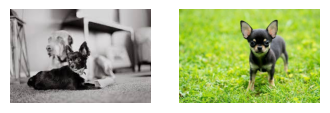

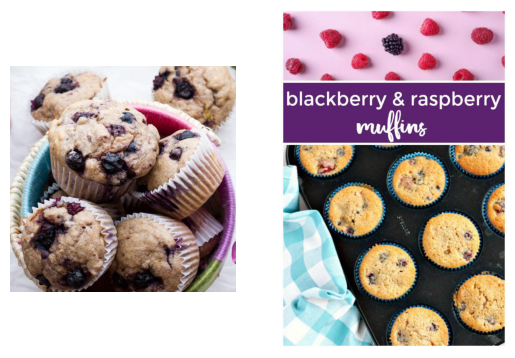

In [ ]:
# Set up matplotlib fig, and size it to fit 1x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index+=8

next_muffin_pix = [os.path.join(train_muffin_dir, fname)
                for fname in train_muffin_fnames[ pic_index-2:pic_index]
               ]

next_chihuahua_pix = [os.path.join(train_chihuahua_dir, fname)
                for fname in train_chihuahua_fnames[ pic_index-2:pic_index]
               ]


for i, img_path in enumerate(next_chihuahua_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

for i, img_path in enumerate(next_muffin_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

###Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. I have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, I will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows me to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

###Example of resizing and grayscalling images

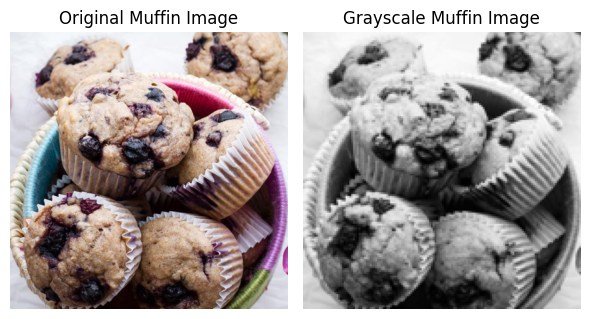

In [ ]:
image_path = next_muffin_pix[0]
image = Image.open(image_path)

new_size = (150, 150)  # Define the desired size
resized_image = image.resize(new_size)

grayscale_image = resized_image.convert("L")

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

axs[0].imshow(image)
axs[0].set_title("Original Muffin Image")
axs[0].axis('off')

axs[1].imshow(grayscale_image, cmap='gray')
axs[1].set_title("Grayscale Muffin Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

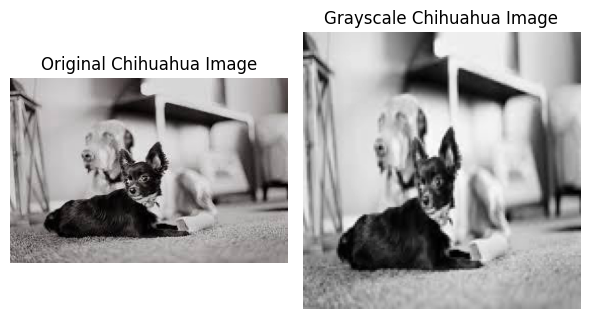

In [ ]:
image_path = next_chihuahua_pix[0]
image = Image.open(image_path)

new_size = (150, 150)  # Define the desired size
resized_image = image.resize(new_size)

grayscale_image = resized_image.convert("L")

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

axs[0].imshow(image)
axs[0].set_title("Original Chihuahua Image")
axs[0].axis('off')

axs[1].imshow(grayscale_image, cmap='gray')
axs[1].set_title("Grayscale Chihuahua Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

###Example of Convolution on test dataset

In [ ]:
import numpy as np

ascent_image = image
new_size = (150, 150)  # For example purposes
resized_image = ascent_image.resize(new_size)
grayscale_image = resized_image.convert("L")

#Convert the image to a NumPy array:
image_array = np.array(grayscale_image)

#Normalize the image array:
image_array = image_array.astype('float32') / 255.0


The image is stored as a numpy array so I can create the transformed image by first copying that array. I can also get the dimensions of the image so I can loop over it later.



In [ ]:
import numpy as np

# Copy image to a numpy array
image_transformed = np.copy(image_array)

# Get the dimensions of the image
size_x = image_transformed.shape[0]
size_y = image_transformed.shape[1]

Now I can create a filter as a 3x3 array.

In [ ]:
# Experimental filters
filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]
#filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
#filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

weight  = 1


Now I can create a convolution. I will iterate over the image, leaving a 1 pixel margin, and multiplying each of the neighbors of the current pixel by the value defined in the filter (i.e. the current pixel's neighbor above it and to the left will be multiplied by the top left item in the filter, etc.)

I'll then multiply the result by the weight, and then ensure the result is in the range 0-255.

Finally I'll load the new value into the transformed image.

In [ ]:
# Iterate over the image
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (image_array[x-1, y-1] * filter[0][0])
      convolution = convolution + (image_array[x-1, y] * filter[0][1])
      convolution = convolution + (image_array[x-1, y+1] * filter[0][2])
      convolution = convolution + (image_array[x, y-1] * filter[1][0])
      convolution = convolution + (image_array[x, y] * filter[1][1])
      convolution = convolution + (image_array[x, y+1] * filter[1][2])
      convolution = convolution + (image_array[x+1, y-1] * filter[2][0])
      convolution = convolution + (image_array[x+1, y] * filter[2][1])
      convolution = convolution + (image_array[x+1, y+1] * filter[2][2])

      # Multiply by weight
      convolution = convolution * weight

      # Check the boundaries of the pixel values
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255

      # Load into the transformed image
      image_transformed[x, y] = convolution

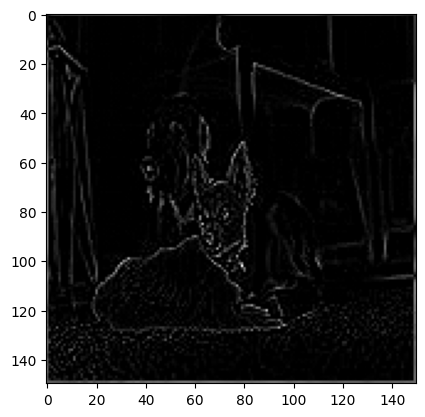

In [ ]:
# Plot the image. Note the size of the axes -- they are 512 by 512
plt.gray()
plt.grid(False)
plt.imshow(image_transformed)
plt.show()

###Example of Max Pooling on test dataset

The next cell will show a (2, 2) pooling. The idea here is to iterate over the image, and look at the pixel and it's immediate neighbors to the right, beneath, and right-beneath. It will take the largest of them and load it into the new image. Thus, the new image will be 1/4 the size of the old -- with the dimensions on X and Y being halved by this process. You'll see that the features get maintained despite this compression!

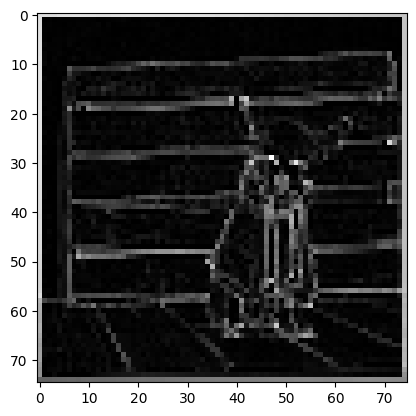

In [ ]:
# Assign dimensions half the size of the original image
new_x = int(size_x/2)
new_y = int(size_y/2)

# Create blank image with reduced dimensions
newImage = np.zeros((new_x, new_y))

# Iterate over the image
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):

    # Store all the pixel values in the (2,2) pool
    pixels = []
    pixels.append(image_transformed[x, y])
    pixels.append(image_transformed[x+1, y])
    pixels.append(image_transformed[x, y+1])
    pixels.append(image_transformed[x+1, y+1])

    # Get only the largest value and assign to the reduced image
    newImage[int(x/2),int(y/2)] = max(pixels)

plt.gray()
plt.grid(False)
plt.imshow(newImage)
plt.show()

###Example of Augmentation on test dataset

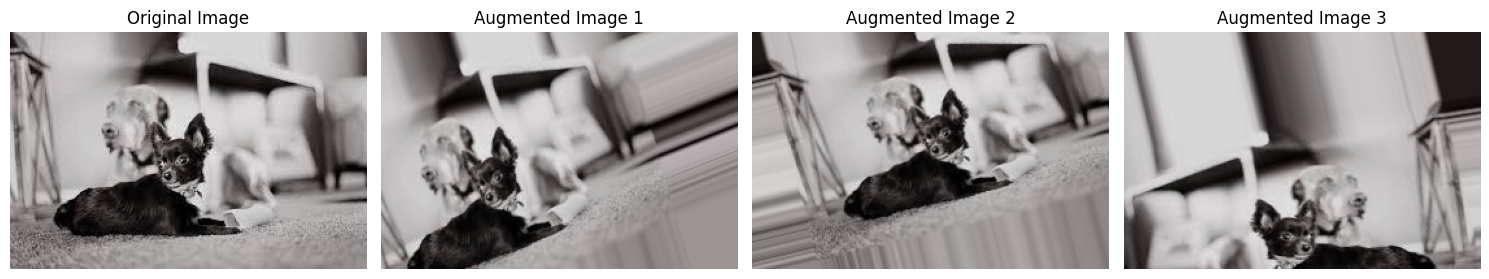

In [ ]:
# Load your image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Load your image
image_path = next_chihuahua_pix[0]
image = Image.open(image_path)

# Convert the image to numpy array
image_array = np.array(image)

# Reshape the image array for augmentation
augmentation_input = image_array.reshape((1,) + image_array.shape)

# Create an instance of ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = datagen.flow(augmentation_input, batch_size=1)

# Display the original and augmented images
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot the original image
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Plot the augmented images
for i in range(1, 4):
    augmented_image = next(augmented_images)[0].astype(np.uint8)
    axs[i].imshow(augmented_image)
    axs[i].set_title(f"Augmented Image {i}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Arhitectures and Building models

###Data Final Processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:

# Reshape and load the training images
train_images = []
train_labels = []

for filename in os.listdir(train_chihuahua_dir):
    img = Image.open(os.path.join(train_chihuahua_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150) if needed
    img_array = np.array(img)
    train_images.append(img_array)
    train_labels.append(0)  # Assign label 0 for chihuahua

for filename in os.listdir(train_muffin_dir):
    img = Image.open(os.path.join(train_muffin_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150) if needed
    img_array = np.array(img)
    train_images.append(img_array)
    train_labels.append(1)  # Assign label 1 for muffin

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Reshape and load the validation images
validation_images = []
validation_labels = []

for filename in os.listdir(validation_chihuahua_dir):
    img = Image.open(os.path.join(validation_chihuahua_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    validation_images.append(img_array)
    validation_labels.append(0)  # Assign label 0 for chihuahua

for filename in os.listdir(validation_muffin_dir):
    img = Image.open(os.path.join(validation_muffin_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    validation_images.append(img_array)
    validation_labels.append(1)  # Assign label 1 for muffin

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

In [ ]:
train_images  = train_images / 255.0
validation_images = validation_images / 255.0

train_images = tf.convert_to_tensor(train_images)
validation_images = tf.convert_to_tensor(validation_images)

In [ ]:
sizet = train_images.shape[0]
sizev = validation_images.shape[0]

train_labels = tf.reshape(tf.convert_to_tensor(train_labels, dtype=tf.float32), shape = [sizet, 1])
validation_labels = tf.reshape(tf.convert_to_tensor(validation_labels, dtype=tf.float32), shape = [sizev, 1])

print(sizet)
print(sizev)

4733
1184


In [ ]:
#Building plots
legend_size = 14

def plotting_the_result(history):
    plt.figure(figsize=(20,8))

    #Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    #Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    plt.show()

###Architecture 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop


EPOCH = 50

Epoch 1/50
148/148 [==============================] - 7s 7ms/step - loss: 3.0483 - accuracy: 0.5371 - val_loss: 1.9608 - val_accuracy: 0.5422
Epoch 2/50
148/148 [==============================] - 1s 5ms/step - loss: 2.4766 - accuracy: 0.5145 - val_loss: 1.6078 - val_accuracy: 0.4764
Epoch 3/50
148/148 [==============================] - 1s 5ms/step - loss: 2.2105 - accuracy: 0.5204 - val_loss: 3.1997 - val_accuracy: 0.5405
Epoch 4/50
148/148 [==============================] - 1s 5ms/step - loss: 1.9597 - accuracy: 0.5312 - val_loss: 1.2100 - val_accuracy: 0.5169
Epoch 5/50
148/148 [==============================] - 1s 5ms/step - loss: 0.7721 - accuracy: 0.5170 - val_loss: 0.6922 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 1s 5ms/step - loss: 0.6916 - accuracy: 0.5407 - val_loss: 0.6910 - val_accuracy: 0.5405
Epoch 7/50
148/148 [==============================] - 1s 5ms/step - loss: 0.6907 - accuracy: 0.5407 - val_loss: 0.6904 - val_accuracy: 0.5405
Epoch 

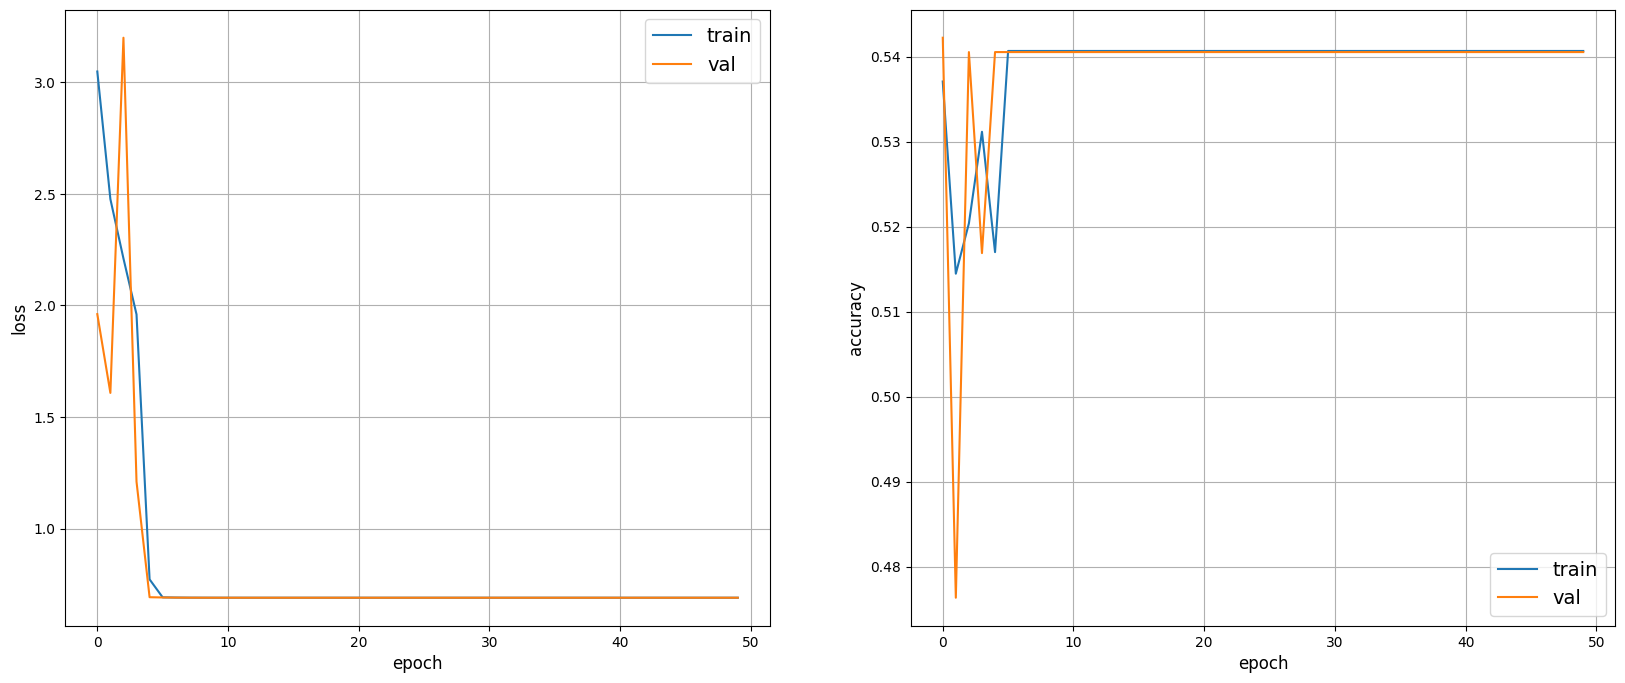

37/37 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5405
Test loss and accuracy: [0.6898574829101562, 0.5405405163764954]


In [ ]:
# Build the classification model
model1_32 = tf.keras.models.Sequential([
     # tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
     # tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model1_32.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model1_32.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model1_32.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 3s 12ms/step - loss: 2.8526 - accuracy: 0.5039 - val_loss: 2.7845 - val_accuracy: 0.5405
Epoch 2/50
148/148 [==============================] - 2s 10ms/step - loss: 1.5844 - accuracy: 0.5286 - val_loss: 1.5340 - val_accuracy: 0.4654
Epoch 3/50
148/148 [==============================] - 2s 10ms/step - loss: 1.1206 - accuracy: 0.5453 - val_loss: 0.6619 - val_accuracy: 0.6166
Epoch 4/50
148/148 [==============================] - 2s 11ms/step - loss: 0.8417 - accuracy: 0.5179 - val_loss: 0.6929 - val_accuracy: 0.5422
Epoch 5/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6921 - accuracy: 0.5407 - val_loss: 0.6912 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 2s 11ms/step - loss: 0.7007 - accuracy: 0.5400 - val_loss: 0.6899 - val_accuracy: 0.5414
Epoch 7/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6860 - accuracy: 0.5411 - val_loss: 0.6822 - val_accuracy: 0.5414

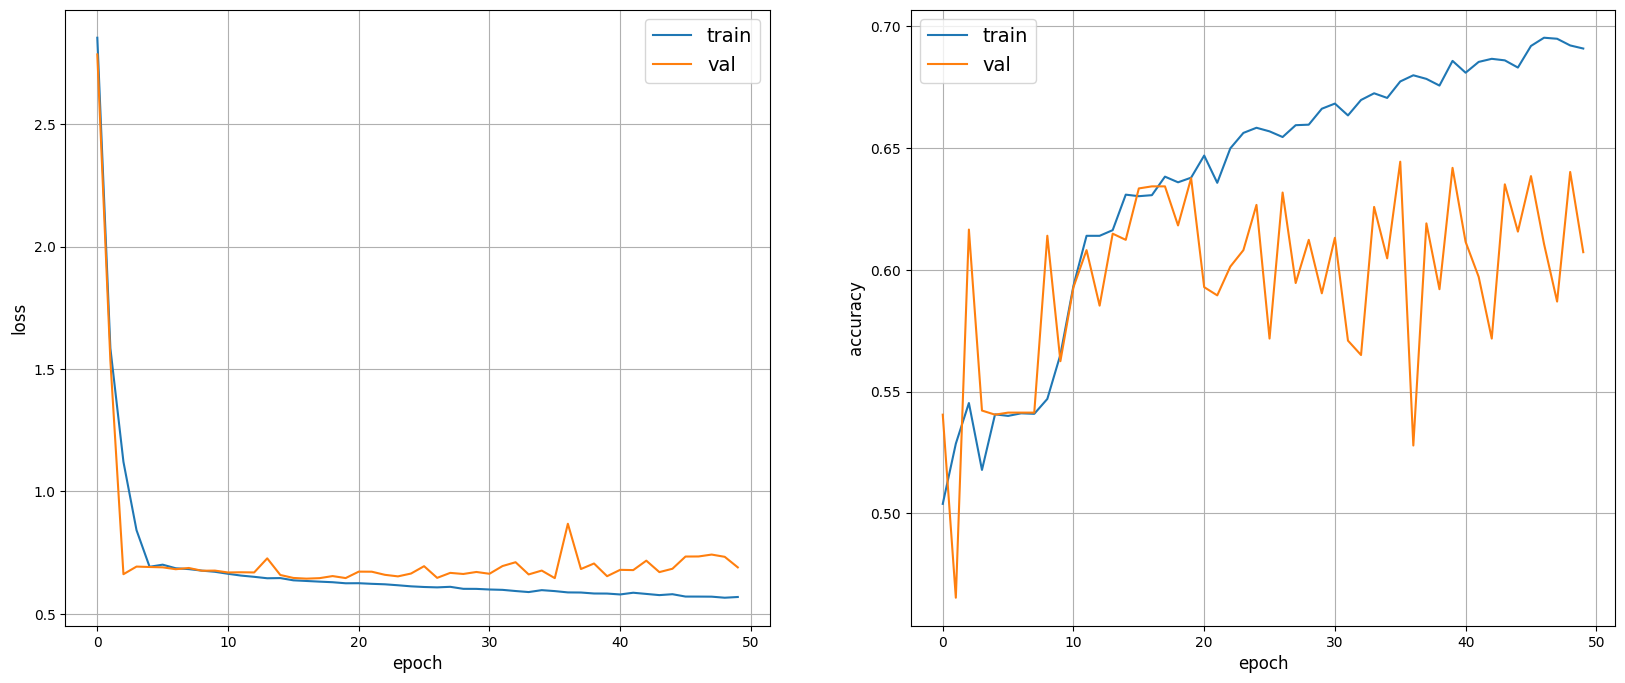

37/37 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.6073
Test loss and accuracy: [0.6897113919258118, 0.6072635054588318]


In [ ]:
# Build the classification model
model1_64 = tf.keras.models.Sequential([
     # tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
     # tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model1_64.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model1_64.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model1_64.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 5s 29ms/step - loss: 6.9644 - accuracy: 0.5193 - val_loss: 0.9296 - val_accuracy: 0.5988
Epoch 2/50
148/148 [==============================] - 4s 27ms/step - loss: 3.4608 - accuracy: 0.5265 - val_loss: 0.8398 - val_accuracy: 0.5718
Epoch 3/50
148/148 [==============================] - 7s 45ms/step - loss: 1.7015 - accuracy: 0.5436 - val_loss: 1.5588 - val_accuracy: 0.5422
Epoch 4/50
148/148 [==============================] - 8s 54ms/step - loss: 0.8464 - accuracy: 0.5422 - val_loss: 0.6671 - val_accuracy: 0.5659
Epoch 5/50
148/148 [==============================] - 6s 37ms/step - loss: 0.6926 - accuracy: 0.5669 - val_loss: 0.6642 - val_accuracy: 0.5752
Epoch 6/50
148/148 [==============================] - 5s 35ms/step - loss: 0.6739 - accuracy: 0.5829 - val_loss: 0.6621 - val_accuracy: 0.5785
Epoch 7/50
148/148 [==============================] - 5s 33ms/step - loss: 0.6677 - accuracy: 0.5903 - val_loss: 0.6675 - val_accuracy: 0.6233

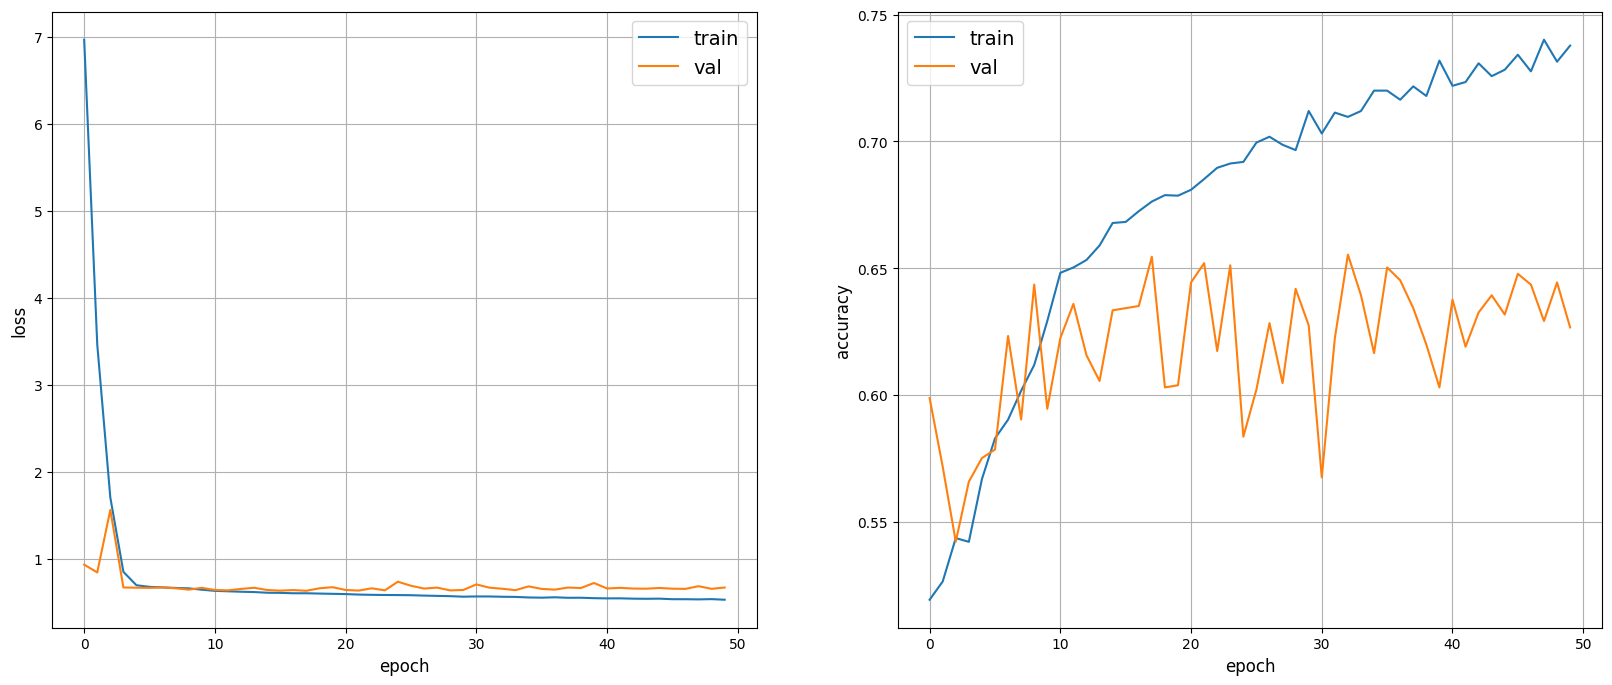

37/37 [==============================] - 0s 7ms/step - loss: 0.6664 - accuracy: 0.6267
Test loss and accuracy: [0.6663784980773926, 0.6266891956329346]


In [ ]:
# Build the classification model
model1_128 = tf.keras.models.Sequential([
     # tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
     # tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model1_128.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model1_128.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model1_128.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 7s 46ms/step - loss: 7.3901 - accuracy: 0.5145 - val_loss: 0.9891 - val_accuracy: 0.6275
Epoch 2/50
148/148 [==============================] - 7s 48ms/step - loss: 3.2600 - accuracy: 0.5282 - val_loss: 1.4583 - val_accuracy: 0.4890
Epoch 3/50
148/148 [==============================] - 6s 40ms/step - loss: 1.2313 - accuracy: 0.5517 - val_loss: 0.7169 - val_accuracy: 0.5110
Epoch 4/50
148/148 [==============================] - 8s 51ms/step - loss: 0.6662 - accuracy: 0.5950 - val_loss: 0.6432 - val_accuracy: 0.6301
Epoch 5/50
148/148 [==============================] - 6s 41ms/step - loss: 0.6477 - accuracy: 0.6199 - val_loss: 0.6858 - val_accuracy: 0.5726
Epoch 6/50
148/148 [==============================] - 7s 48ms/step - loss: 0.6289 - accuracy: 0.6351 - val_loss: 0.8378 - val_accuracy: 0.5118
Epoch 7/50
148/148 [==============================] - 6s 43ms/step - loss: 0.6366 - accuracy: 0.6362 - val_loss: 0.7245 - val_accuracy: 0.5752

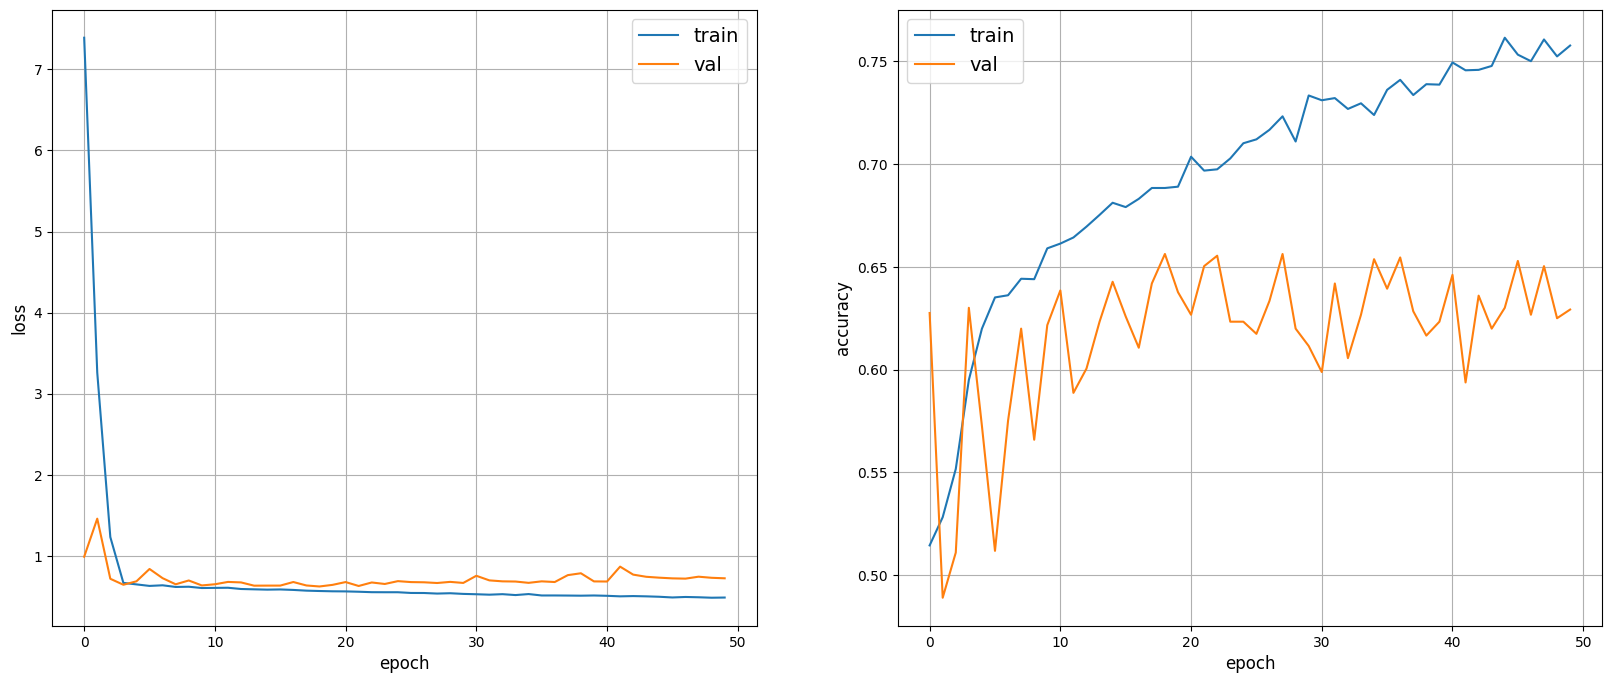

37/37 [==============================] - 0s 11ms/step - loss: 0.7229 - accuracy: 0.6292
Test loss and accuracy: [0.722870945930481, 0.6292229890823364]


In [ ]:
# Build the classification model
model1_256 = tf.keras.models.Sequential([
     # tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
     # tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model1_256.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model1_256.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model1_256.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 22s 143ms/step - loss: 5.8466 - accuracy: 0.5267 - val_loss: 1.2660 - val_accuracy: 0.4789
Epoch 2/50
148/148 [==============================] - 20s 137ms/step - loss: 1.6880 - accuracy: 0.5246 - val_loss: 1.1792 - val_accuracy: 0.5397
Epoch 3/50
148/148 [==============================] - 20s 136ms/step - loss: 0.7321 - accuracy: 0.5508 - val_loss: 0.6828 - val_accuracy: 0.5405
Epoch 4/50
148/148 [==============================] - 20s 138ms/step - loss: 0.6787 - accuracy: 0.5681 - val_loss: 0.6500 - val_accuracy: 0.6208
Epoch 5/50
148/148 [==============================] - 20s 138ms/step - loss: 0.6487 - accuracy: 0.6041 - val_loss: 0.6517 - val_accuracy: 0.6064
Epoch 6/50
148/148 [==============================] - 20s 132ms/step - loss: 0.6382 - accuracy: 0.6273 - val_loss: 0.7159 - val_accuracy: 0.5532
Epoch 7/50
148/148 [==============================] - 20s 138ms/step - loss: 0.6338 - accuracy: 0.6324 - val_loss: 0.6327 - val_ac

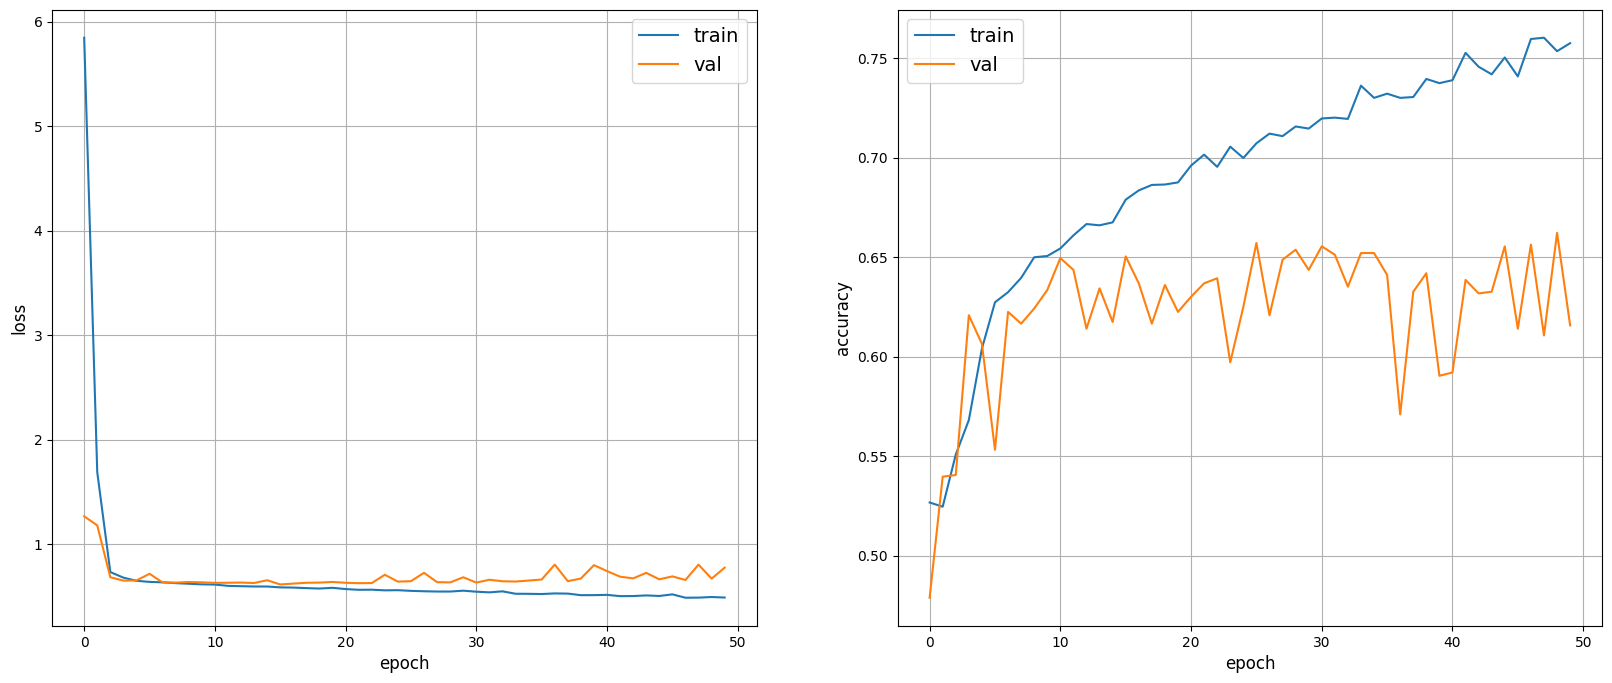

37/37 [==============================] - 1s 28ms/step - loss: 0.7742 - accuracy: 0.6157
Test loss and accuracy: [0.7741851806640625, 0.6157094836235046]


In [ ]:
# Build the classification model
model1_512 = tf.keras.models.Sequential([
     # tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
     # tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model1_512.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model1_512.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model1_512.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

###Architecture 2

Epoch 1/50
148/148 [==============================] - 105s 704ms/step - loss: 1.1575 - accuracy: 0.6417 - val_loss: 0.4924 - val_accuracy: 0.7880
Epoch 2/50
148/148 [==============================] - 84s 565ms/step - loss: 0.4811 - accuracy: 0.7894 - val_loss: 0.8102 - val_accuracy: 0.5929
Epoch 3/50
148/148 [==============================] - 82s 554ms/step - loss: 0.3940 - accuracy: 0.8223 - val_loss: 0.4557 - val_accuracy: 0.7787
Epoch 4/50
148/148 [==============================] - 84s 566ms/step - loss: 0.3208 - accuracy: 0.8625 - val_loss: 0.4186 - val_accuracy: 0.8091
Epoch 5/50
148/148 [==============================] - 83s 559ms/step - loss: 0.2502 - accuracy: 0.9049 - val_loss: 0.4183 - val_accuracy: 0.8285
Epoch 6/50
148/148 [==============================] - 88s 597ms/step - loss: 0.1819 - accuracy: 0.9402 - val_loss: 0.4267 - val_accuracy: 0.8193
Epoch 7/50
148/148 [==============================] - 83s 560ms/step - loss: 0.1355 - accuracy: 0.9542 - val_loss: 0.4857 - val_a

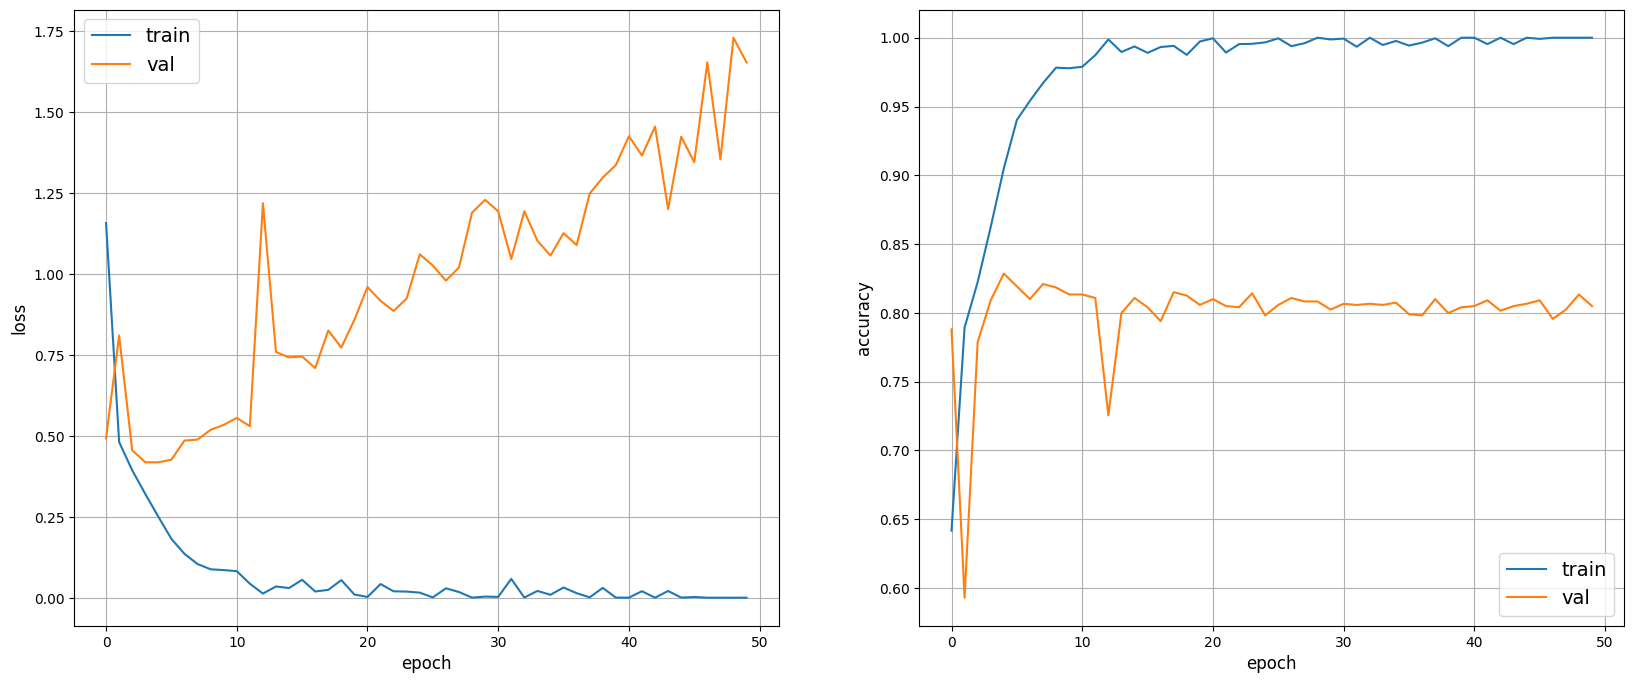

37/37 [==============================] - 5s 121ms/step - loss: 1.6537 - accuracy: 0.8049
Test loss and accuracy: [1.653733253479004, 0.8048986196517944]


In [ ]:
# Build the classification model
model2_32 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model2_32.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model2_32.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model2_32.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 126s 848ms/step - loss: 0.7757 - accuracy: 0.6110 - val_loss: 0.5840 - val_accuracy: 0.7508
Epoch 2/50
148/148 [==============================] - 126s 850ms/step - loss: 0.5528 - accuracy: 0.7412 - val_loss: 0.4652 - val_accuracy: 0.8117
Epoch 3/50
148/148 [==============================] - 126s 850ms/step - loss: 0.4328 - accuracy: 0.8052 - val_loss: 0.6938 - val_accuracy: 0.6723
Epoch 4/50
148/148 [==============================] - 128s 864ms/step - loss: 0.3624 - accuracy: 0.8437 - val_loss: 0.4027 - val_accuracy: 0.8133
Epoch 5/50
148/148 [==============================] - 128s 865ms/step - loss: 0.2727 - accuracy: 0.8838 - val_loss: 0.4510 - val_accuracy: 0.7905
Epoch 6/50
148/148 [==============================] - 127s 857ms/step - loss: 0.2056 - accuracy: 0.9180 - val_loss: 0.4685 - val_accuracy: 0.8226
Epoch 7/50
148/148 [==============================] - 127s 858ms/step - loss: 0.1512 - accuracy: 0.9438 - val_loss: 0.7372 -

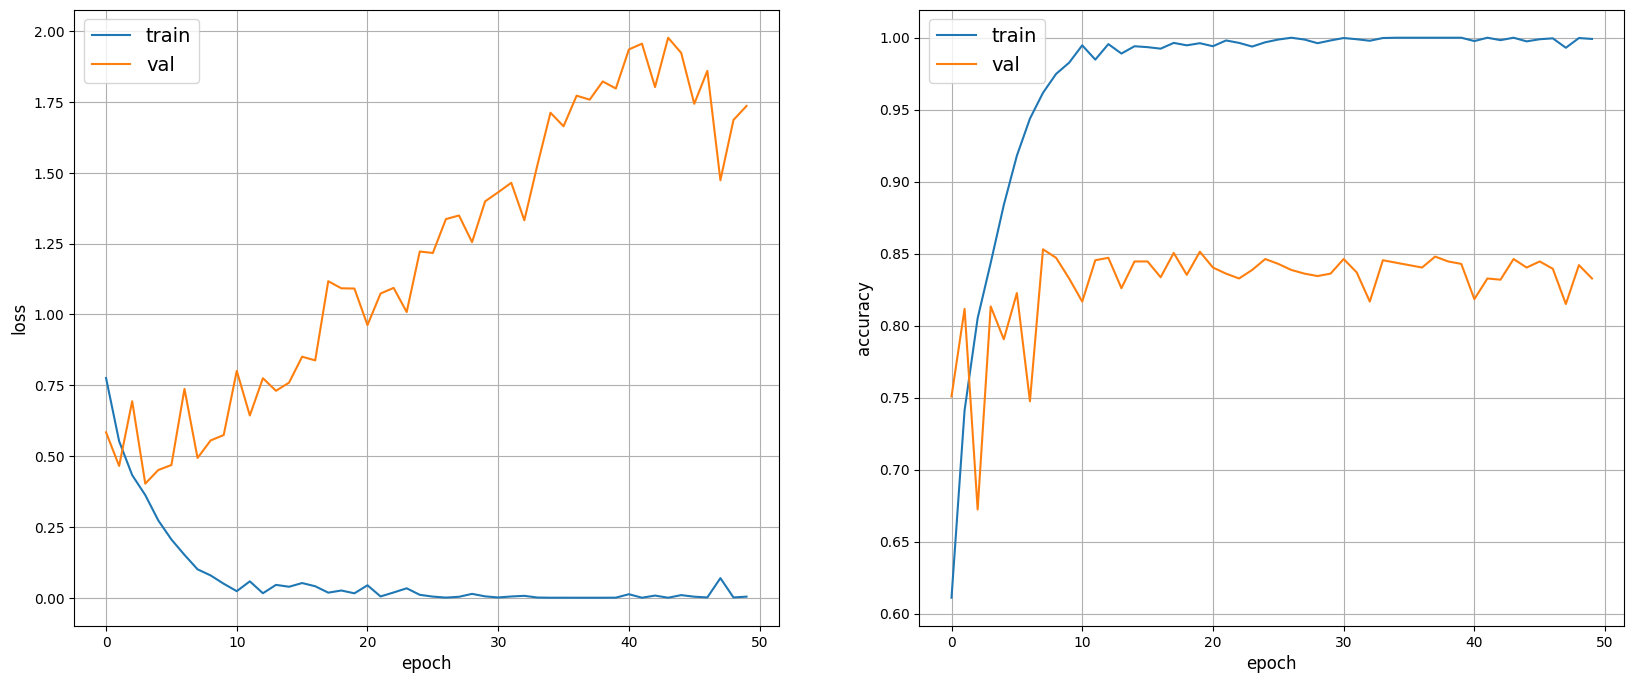

37/37 [==============================] - 8s 211ms/step - loss: 1.7362 - accuracy: 0.8328
Test loss and accuracy: [1.7362275123596191, 0.8327702879905701]


In [ ]:
# Build the classification model
model2_64 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model2_64.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model2_64.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))
#here 20
plotting_the_result(history)

# Evaluate the model on unseen data
result = model2_64.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 191s 1s/step - loss: 0.6692 - accuracy: 0.6091 - val_loss: 0.6433 - val_accuracy: 0.5980
Epoch 2/50
148/148 [==============================] - 153s 1s/step - loss: 0.5255 - accuracy: 0.7558 - val_loss: 0.4620 - val_accuracy: 0.7829
Epoch 3/50
148/148 [==============================] - 155s 1s/step - loss: 0.4537 - accuracy: 0.7923 - val_loss: 0.4004 - val_accuracy: 0.8226
Epoch 4/50
148/148 [==============================] - 153s 1s/step - loss: 0.3661 - accuracy: 0.8388 - val_loss: 0.4705 - val_accuracy: 0.7973
Epoch 5/50
148/148 [==============================] - 155s 1s/step - loss: 0.3183 - accuracy: 0.8627 - val_loss: 0.3949 - val_accuracy: 0.8142
Epoch 6/50
148/148 [==============================] - 152s 1s/step - loss: 0.2566 - accuracy: 0.8912 - val_loss: 0.3994 - val_accuracy: 0.8294
Epoch 7/50
148/148 [==============================] - 155s 1s/step - loss: 0.2136 - accuracy: 0.9176 - val_loss: 0.3786 - val_accuracy: 0.8471

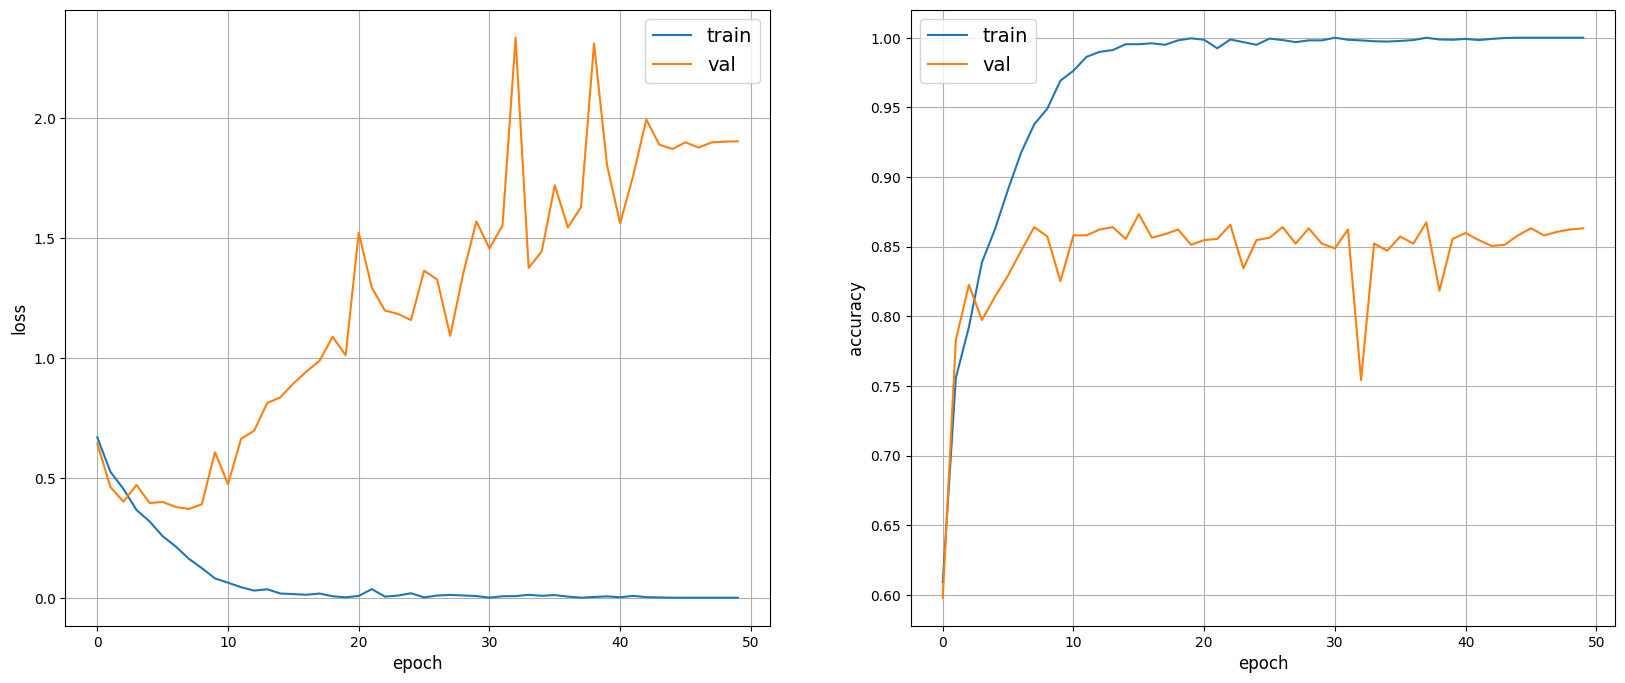

37/37 [==============================] - 10s 268ms/step - loss: 1.9038 - accuracy: 0.8632
Test loss and accuracy: [1.9037607908248901, 0.8631756901741028]


In [ ]:
# Build the classification model
model2_128 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model2_128.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model2_128.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels))

plotting_the_result(history)

# Evaluate the model on unseen data
result = model2_128.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

In [ ]:
#Add the breaker after the accuracy 1.0 on training set

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') >= 1.000):

      # Stop if threshold is met
      print("\Accuracy is equal 1.000 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

Epoch 1/50
148/148 [==============================] - 153s 1s/step - loss: 0.6704 - accuracy: 0.5971 - val_loss: 0.5516 - val_accuracy: 0.7145
Epoch 2/50
148/148 [==============================] - 143s 967ms/step - loss: 0.5218 - accuracy: 0.7564 - val_loss: 0.5770 - val_accuracy: 0.7188
Epoch 3/50
148/148 [==============================] - 145s 977ms/step - loss: 0.4497 - accuracy: 0.7946 - val_loss: 0.4091 - val_accuracy: 0.8176
Epoch 4/50
148/148 [==============================] - 142s 961ms/step - loss: 0.3813 - accuracy: 0.8286 - val_loss: 0.3619 - val_accuracy: 0.8387
Epoch 5/50
148/148 [==============================] - 141s 950ms/step - loss: 0.3349 - accuracy: 0.8542 - val_loss: 0.4129 - val_accuracy: 0.8328
Epoch 6/50
148/148 [==============================] - 142s 962ms/step - loss: 0.2828 - accuracy: 0.8802 - val_loss: 0.4238 - val_accuracy: 0.8260
Epoch 7/50
148/148 [==============================] - 140s 948ms/step - loss: 0.2290 - accuracy: 0.9022 - val_loss: 0.3768 - va

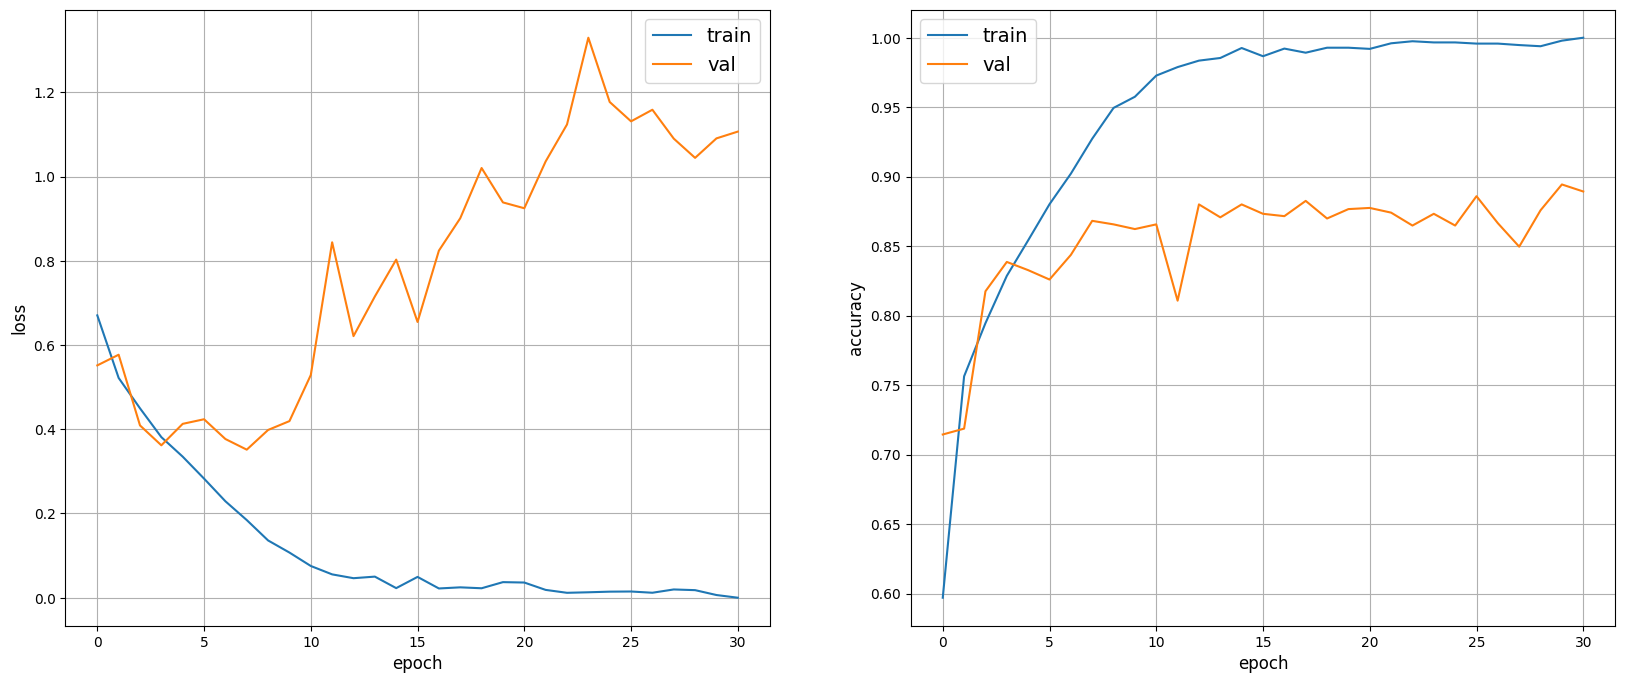

37/37 [==============================] - 9s 252ms/step - loss: 1.1067 - accuracy: 0.8894
Test loss and accuracy: [1.1067067384719849, 0.8893581032752991]


In [ ]:
# Build the classification model
model2_256 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model2_256.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model2_256.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model2_256.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

###Architecture 3

Epoch 1/50
148/148 [==============================] - 133s 890ms/step - loss: 0.6952 - accuracy: 0.5764 - val_loss: 0.7133 - val_accuracy: 0.5236
Epoch 2/50
148/148 [==============================] - 129s 871ms/step - loss: 0.5561 - accuracy: 0.7304 - val_loss: 0.4799 - val_accuracy: 0.7652
Epoch 3/50
148/148 [==============================] - 126s 854ms/step - loss: 0.4502 - accuracy: 0.8010 - val_loss: 0.3788 - val_accuracy: 0.8336
Epoch 4/50
148/148 [==============================] - 127s 857ms/step - loss: 0.3658 - accuracy: 0.8396 - val_loss: 0.5304 - val_accuracy: 0.7787
Epoch 5/50
148/148 [==============================] - 125s 845ms/step - loss: 0.3127 - accuracy: 0.8686 - val_loss: 0.3406 - val_accuracy: 0.8480
Epoch 6/50
148/148 [==============================] - 124s 841ms/step - loss: 0.2523 - accuracy: 0.8969 - val_loss: 0.3472 - val_accuracy: 0.8522
Epoch 7/50
148/148 [==============================] - 123s 832ms/step - loss: 0.2058 - accuracy: 0.9157 - val_loss: 0.5035 -

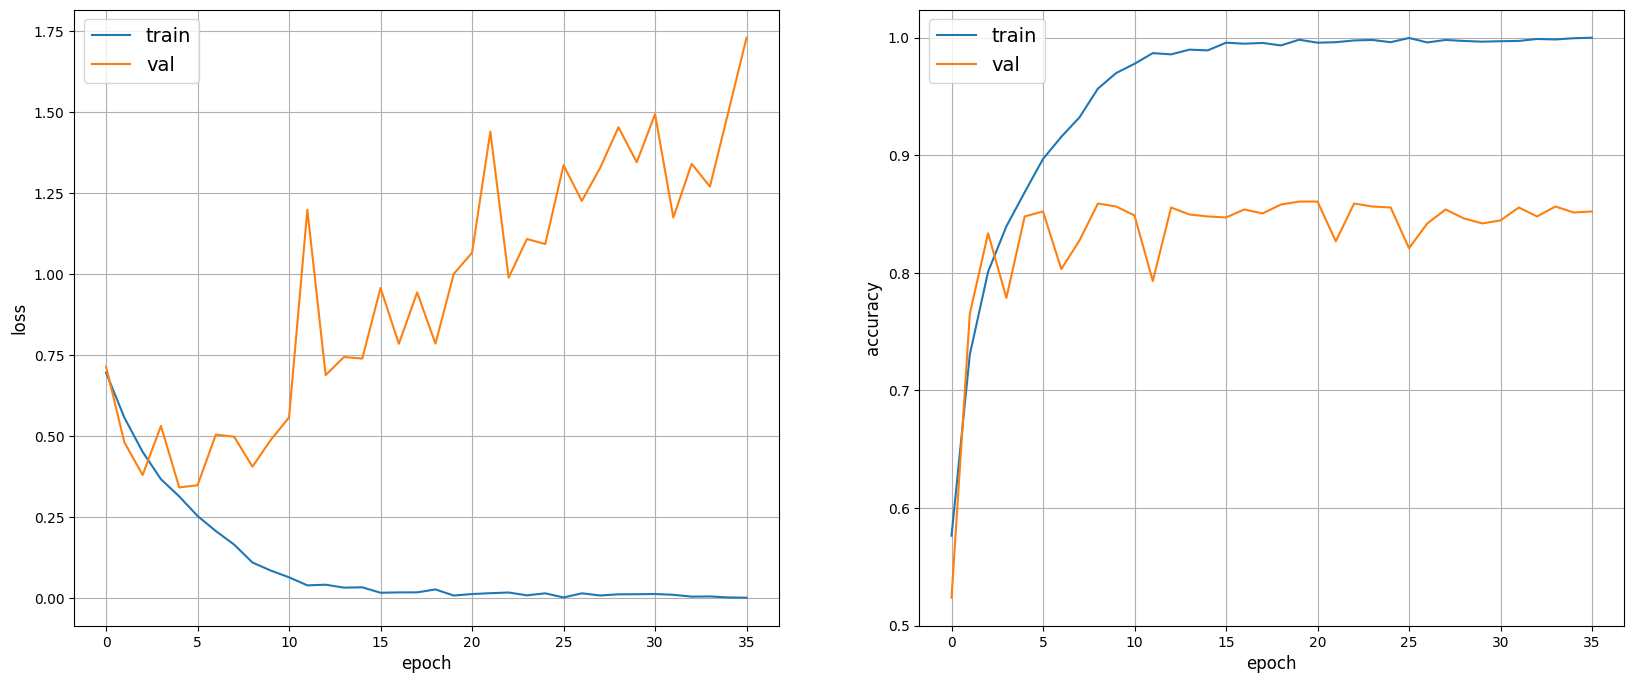

37/37 [==============================] - 9s 241ms/step - loss: 1.7287 - accuracy: 0.8522
Test loss and accuracy: [1.7286510467529297, 0.8521959185600281]


In [ ]:
# Build the classification model
model3_1_01 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_1_01.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model3_1_01.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model3_1_01.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 124s 831ms/step - loss: 0.6875 - accuracy: 0.5844 - val_loss: 0.7359 - val_accuracy: 0.5541
Epoch 2/50
148/148 [==============================] - 123s 830ms/step - loss: 0.5353 - accuracy: 0.7412 - val_loss: 0.4930 - val_accuracy: 0.7492
Epoch 3/50
148/148 [==============================] - 122s 828ms/step - loss: 0.4420 - accuracy: 0.7944 - val_loss: 0.4097 - val_accuracy: 0.8311
Epoch 4/50
148/148 [==============================] - 123s 834ms/step - loss: 0.3802 - accuracy: 0.8297 - val_loss: 0.3334 - val_accuracy: 0.8522
Epoch 5/50
148/148 [==============================] - 122s 827ms/step - loss: 0.3149 - accuracy: 0.8667 - val_loss: 0.3723 - val_accuracy: 0.8260
Epoch 6/50
148/148 [==============================] - 122s 826ms/step - loss: 0.2716 - accuracy: 0.8889 - val_loss: 0.3519 - val_accuracy: 0.8505
Epoch 7/50
148/148 [==============================] - 122s 828ms/step - loss: 0.2236 - accuracy: 0.9072 - val_loss: 0.3077 -

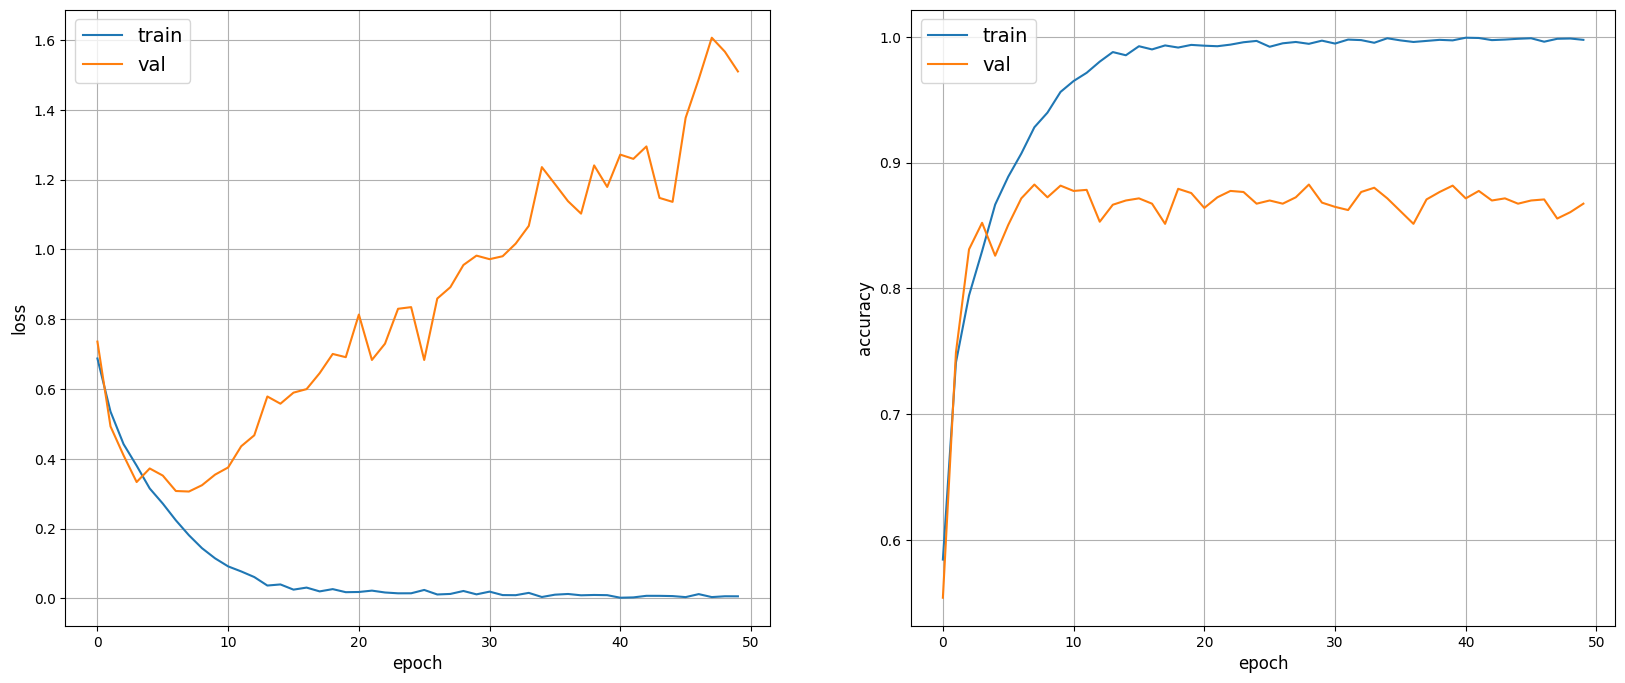

37/37 [==============================] - 8s 205ms/step - loss: 1.5104 - accuracy: 0.8674
Test loss and accuracy: [1.5103728771209717, 0.8673986196517944]


In [ ]:
# Build the classification model
model3_1_05 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_1_05.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model3_1_05.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model3_1_05.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 136s 912ms/step - loss: 0.6721 - accuracy: 0.6117 - val_loss: 0.5330 - val_accuracy: 0.7686
Epoch 2/50
148/148 [==============================] - 134s 903ms/step - loss: 0.5114 - accuracy: 0.7610 - val_loss: 0.4362 - val_accuracy: 0.8243
Epoch 3/50
148/148 [==============================] - 133s 898ms/step - loss: 0.4508 - accuracy: 0.7921 - val_loss: 0.4660 - val_accuracy: 0.7863
Epoch 4/50
148/148 [==============================] - 132s 894ms/step - loss: 0.3965 - accuracy: 0.8259 - val_loss: 0.3791 - val_accuracy: 0.8438
Epoch 5/50
148/148 [==============================] - 132s 890ms/step - loss: 0.3620 - accuracy: 0.8417 - val_loss: 0.3688 - val_accuracy: 0.8370
Epoch 6/50
148/148 [==============================] - 132s 892ms/step - loss: 0.3273 - accuracy: 0.8597 - val_loss: 0.3551 - val_accuracy: 0.8514
Epoch 7/50
148/148 [==============================] - 134s 904ms/step - loss: 0.2884 - accuracy: 0.8829 - val_loss: 0.3271 -

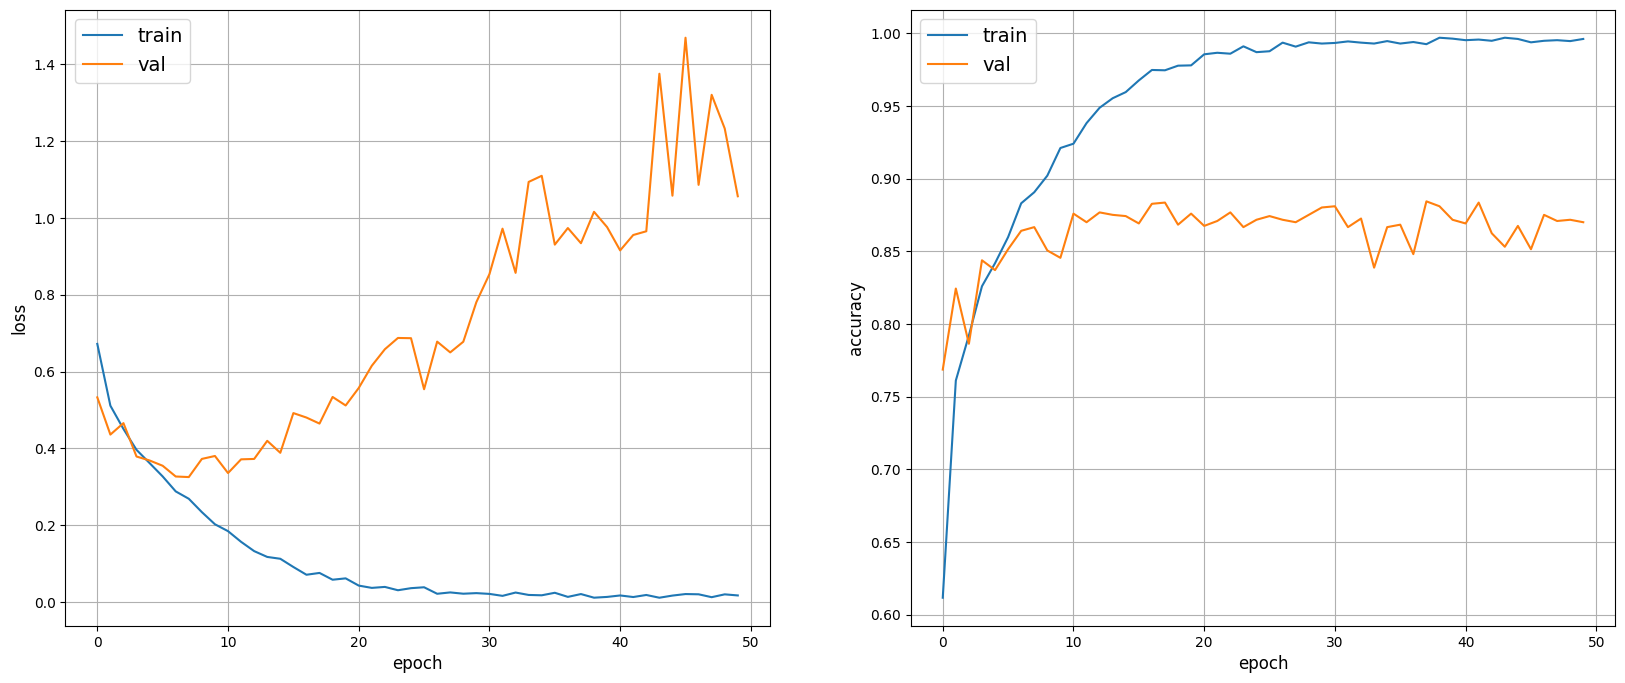

37/37 [==============================] - 8s 204ms/step - loss: 1.0560 - accuracy: 0.8699
Test loss and accuracy: [1.0560208559036255, 0.8699324131011963]


In [ ]:
# Build the classification model
model3_grow_01 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_grow_01.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model3_grow_01.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model3_grow_01.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 13s 13ms/step - loss: 0.8774 - accuracy: 0.5364 - val_loss: 0.6851 - val_accuracy: 0.6436
Epoch 2/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2983 - accuracy: 0.8749 - val_loss: 0.3993 - val_accuracy: 0.8260
Epoch 16/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2875 - accuracy: 0.8810 - val_loss: 0.3461 - val_accuracy: 0.8539
Epoch 17/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2768 - accuracy: 0.8853 - val_loss: 0.3382 - val_accuracy: 0.8480
Epoch 18/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2543 - accuracy: 0.8941 - val_loss: 0.4782 - val_accuracy: 0.8074
Epoch 19/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2562 - accuracy: 0.8977 - val_loss: 0.3011 - val_accuracy: 0.8758
Epoch 20/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2367 - accuracy: 0.9041 - val_loss: 0.3451 - val_accuracy: 0.8505

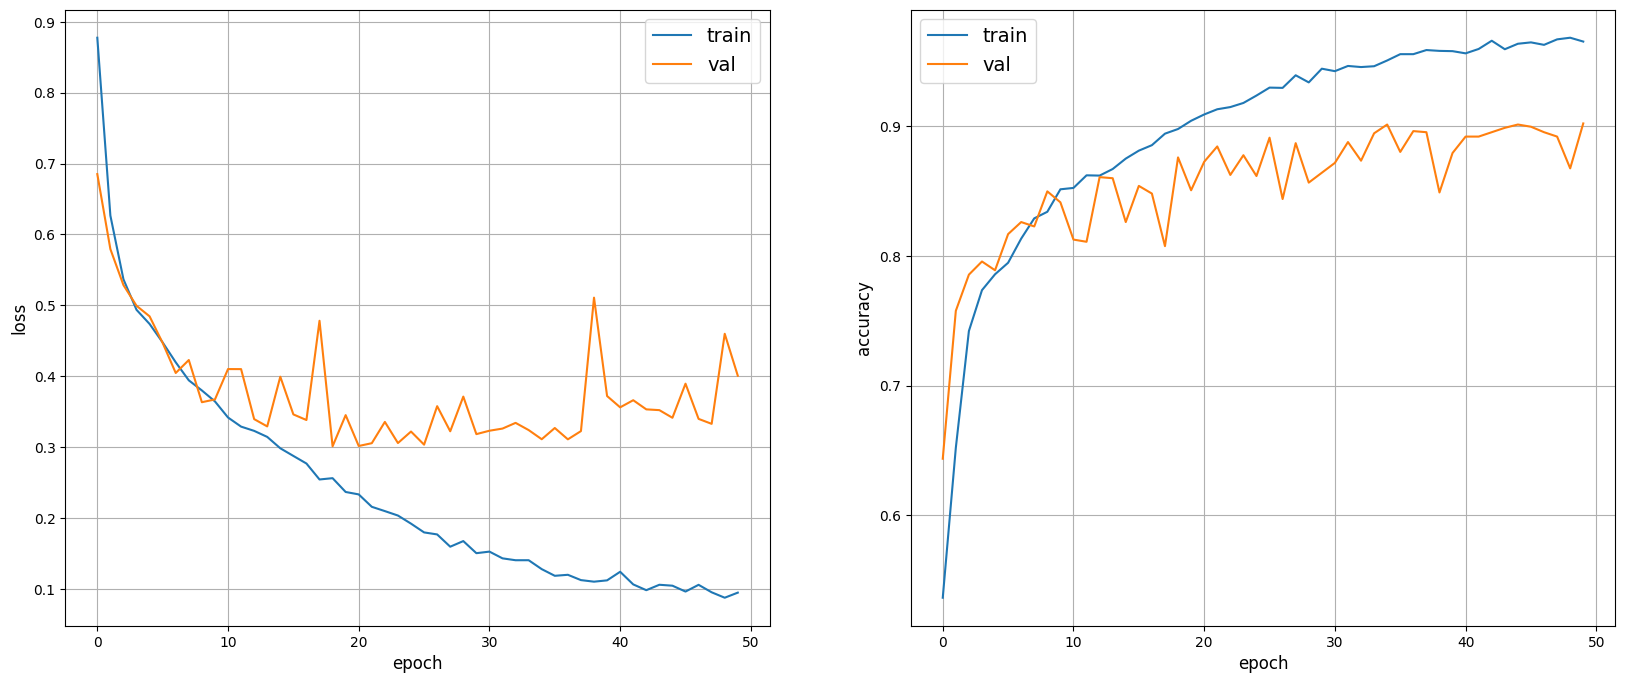

37/37 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.9020
Test loss and accuracy: [0.4006732106208801, 0.9020270109176636]


In [ ]:
# Build the classification model
model3_all_05 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_05.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model3_all_05.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model3_all_05.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
148/148 [==============================] - 3s 9ms/step - loss: 0.6739 - accuracy: 0.6381 - val_loss: 0.5455 - val_accuracy: 0.7660
Epoch 2/50
148/148 [==============================] - 1s 8ms/step - loss: 0.5333 - accuracy: 0.7386 - val_loss: 0.4594 - val_accuracy: 0.8041
Epoch 3/50
148/148 [==============================] - 1s 8ms/step - loss: 0.4589 - accuracy: 0.7889 - val_loss: 0.4264 - val_accuracy: 0.8117
Epoch 4/50
148/148 [==============================] - 1s 8ms/step - loss: 0.3892 - accuracy: 0.8263 - val_loss: 0.3768 - val_accuracy: 0.8294
Epoch 5/50
148/148 [==============================] - 1s 8ms/step - loss: 0.3365 - accuracy: 0.8548 - val_loss: 0.4167 - val_accuracy: 0.8057
Epoch 6/50
148/148 [==============================] - 1s 8ms/step - loss: 0.2940 - accuracy: 0.8724 - val_loss: 0.3351 - val_accuracy: 0.8573
Epoch 7/50
148/148 [==============================] - 1s 9ms/step - loss: 0.2380 - accuracy: 0.9030 - val_loss: 0.3426 - val_accuracy: 0.8497
Epoch 

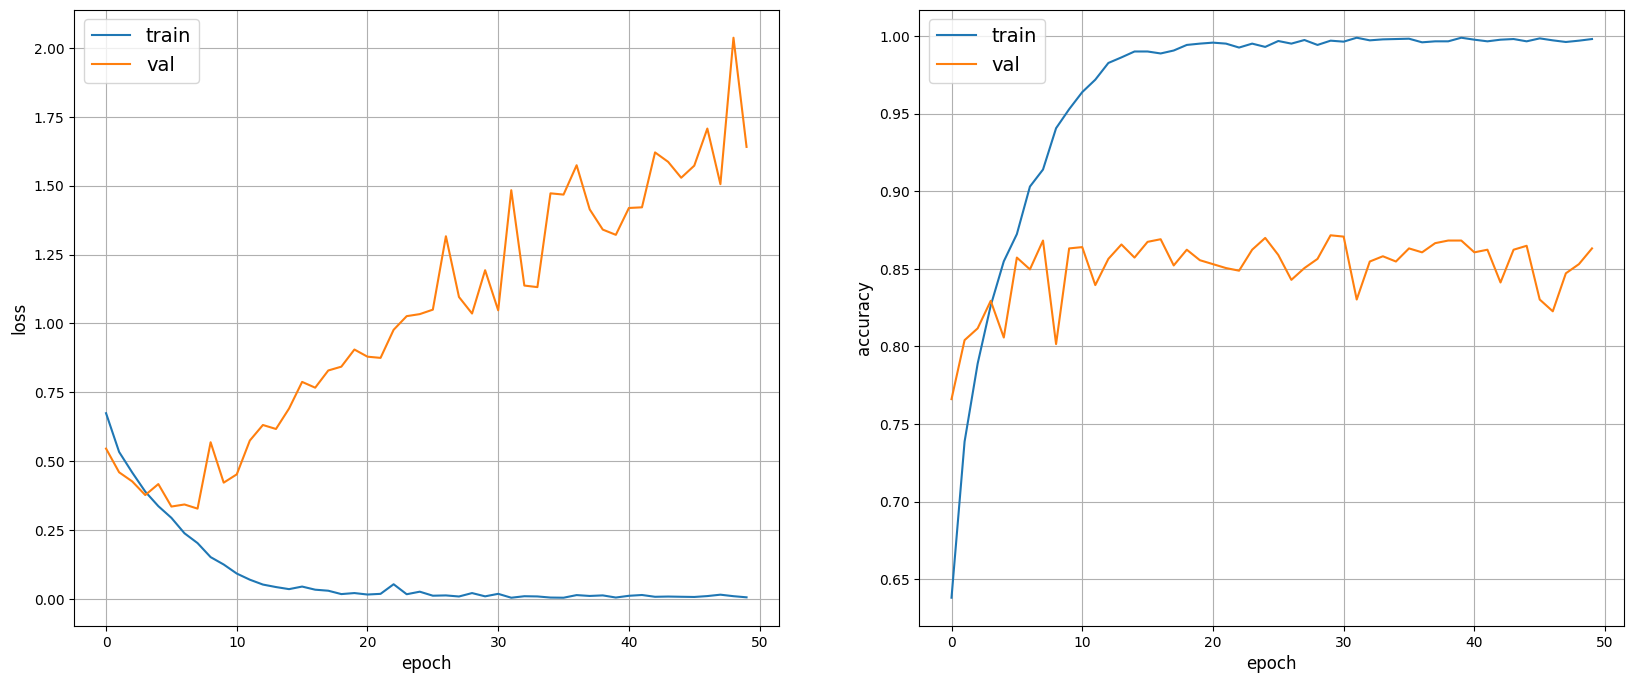

37/37 [==============================] - 0s 4ms/step - loss: 1.6407 - accuracy: 0.8632
Test loss and accuracy: [1.6406605243682861, 0.8631756901741028]


In [ ]:
# Build the classification model
model3_all_01 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_01.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model3_all_01.fit(train_images, train_labels, epochs=EPOCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model3_all_01.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

###Architecture 4

In [ ]:
BATCH = 64

In [ ]:
# Build the classification model
model4_last_b_normz = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

history = model4_last_b_normz.fit(train_images, train_labels, epochs=EPOCH , batch_size = BATCH, validation_data=(validation_images, validation_labels), callbacks=[callbacks])



Epoch 1/50
74/74 [==============================] - 4s 20ms/step - loss: 0.5376 - accuracy: 0.7446 - val_loss: 0.9311 - val_accuracy: 0.5507
Epoch 2/50
74/74 [==============================] - 1s 12ms/step - loss: 0.4156 - accuracy: 0.8198 - val_loss: 0.4873 - val_accuracy: 0.7686
Epoch 3/50
74/74 [==============================] - 1s 12ms/step - loss: 0.3546 - accuracy: 0.8460 - val_loss: 0.3301 - val_accuracy: 0.8682
Epoch 4/50
74/74 [==============================] - 1s 12ms/step - loss: 0.2964 - accuracy: 0.8703 - val_loss: 0.6189 - val_accuracy: 0.7416
Epoch 5/50
74/74 [==============================] - 1s 12ms/step - loss: 0.2491 - accuracy: 0.8948 - val_loss: 0.9623 - val_accuracy: 0.6512
Epoch 6/50
74/74 [==============================] - 1s 12ms/step - loss: 0.2053 - accuracy: 0.9130 - val_loss: 0.2940 - val_accuracy: 0.8834
Epoch 7/50
74/74 [==============================] - 1s 13ms/step - loss: 0.1811 - accuracy: 0.9292 - val_loss: 0.3573 - val_accuracy: 0.8674
Epoch 8/50
74

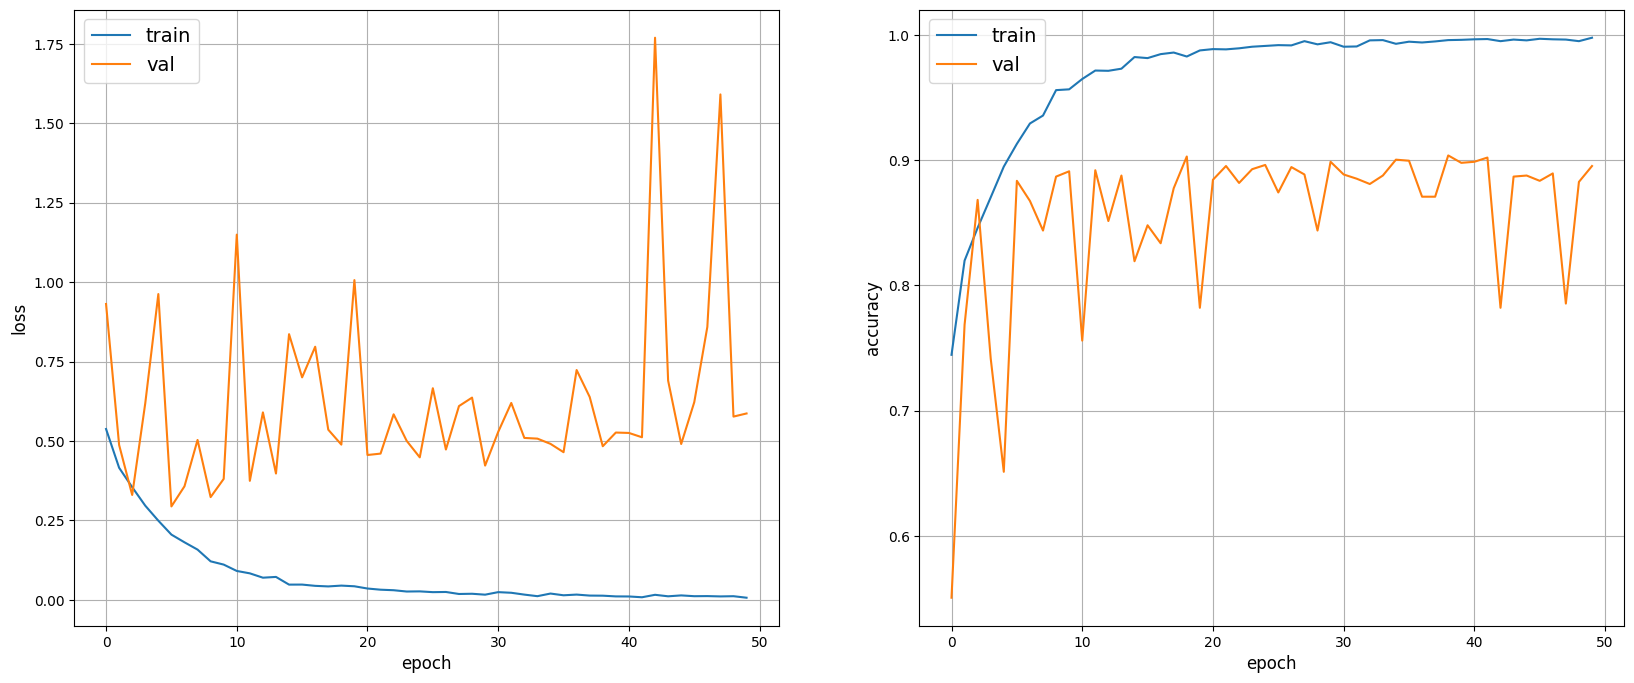

37/37 [==============================] - 0s 4ms/step - loss: 0.5865 - accuracy: 0.8953
Test loss and accuracy: [0.5865463018417358, 0.8952702879905701]


In [ ]:

plotting_the_result(history)

# Evaluate the model on unseen data
result = model4_last_b_normz.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
74/74 [==============================] - 5s 30ms/step - loss: 0.5868 - accuracy: 0.7205 - val_loss: 0.6437 - val_accuracy: 0.7390
Epoch 2/50
74/74 [==============================] - 1s 20ms/step - loss: 0.4707 - accuracy: 0.7910 - val_loss: 0.6461 - val_accuracy: 0.5549
Epoch 3/50
74/74 [==============================] - 1s 20ms/step - loss: 0.4166 - accuracy: 0.8168 - val_loss: 0.8621 - val_accuracy: 0.5405
Epoch 4/50
74/74 [==============================] - 1s 20ms/step - loss: 0.3910 - accuracy: 0.8327 - val_loss: 0.8410 - val_accuracy: 0.5405
Epoch 5/50
74/74 [==============================] - 2s 20ms/step - loss: 0.3744 - accuracy: 0.8382 - val_loss: 0.7742 - val_accuracy: 0.5456
Epoch 6/50
74/74 [==============================] - 1s 20ms/step - loss: 0.3446 - accuracy: 0.8565 - val_loss: 1.2470 - val_accuracy: 0.6174
Epoch 7/50
74/74 [==============================] - 1s 20ms/step - loss: 0.3321 - accuracy: 0.8521 - val_loss: 0.4501 - val_accuracy: 0.7812
Epoch 8/50
74

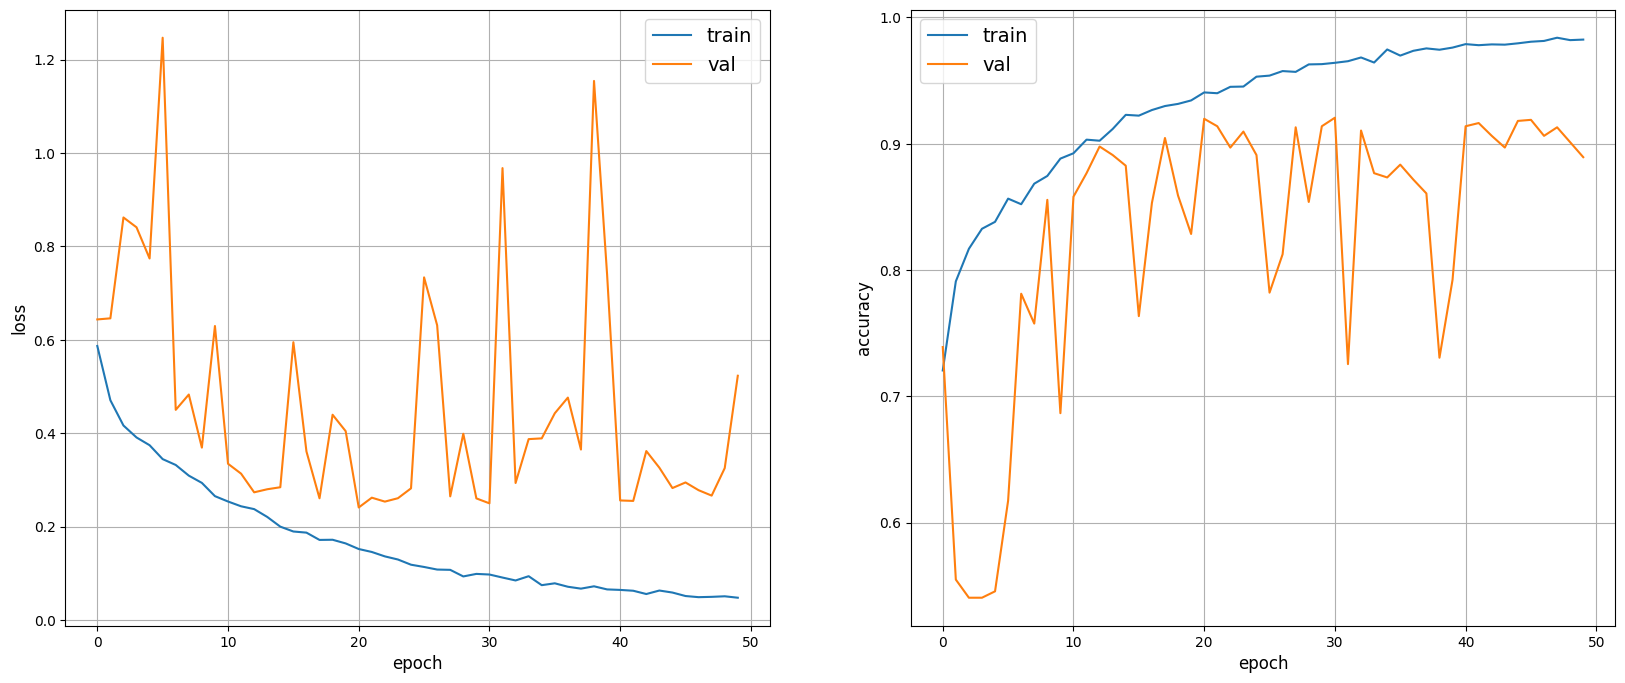

37/37 [==============================] - 0s 4ms/step - loss: 0.5232 - accuracy: 0.8894
Test loss and accuracy: [0.5231567025184631, 0.8893581032752991]


In [ ]:
# Build the classification model
model4_1_last_b_normz = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_1_last_b_normz.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model4_1_last_b_normz.fit(train_images, train_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model4_1_last_b_normz.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
74/74 [==============================] - 4s 25ms/step - loss: 0.5859 - accuracy: 0.7057 - val_loss: 0.9722 - val_accuracy: 0.5405
Epoch 2/50
74/74 [==============================] - 2s 22ms/step - loss: 0.4536 - accuracy: 0.8005 - val_loss: 1.6927 - val_accuracy: 0.5405
Epoch 3/50
74/74 [==============================] - 2s 22ms/step - loss: 0.3938 - accuracy: 0.8308 - val_loss: 2.0555 - val_accuracy: 0.5405
Epoch 4/50
74/74 [==============================] - 2s 22ms/step - loss: 0.3661 - accuracy: 0.8405 - val_loss: 1.3165 - val_accuracy: 0.5397
Epoch 5/50
74/74 [==============================] - 2s 22ms/step - loss: 0.3484 - accuracy: 0.8548 - val_loss: 1.3500 - val_accuracy: 0.5389
Epoch 6/50
74/74 [==============================] - 2s 22ms/step - loss: 0.3167 - accuracy: 0.8652 - val_loss: 1.5745 - val_accuracy: 0.5372
Epoch 7/50
74/74 [==============================] - 2s 22ms/step - loss: 0.2912 - accuracy: 0.8781 - val_loss: 0.8078 - val_accuracy: 0.5642
Epoch 8/50
74

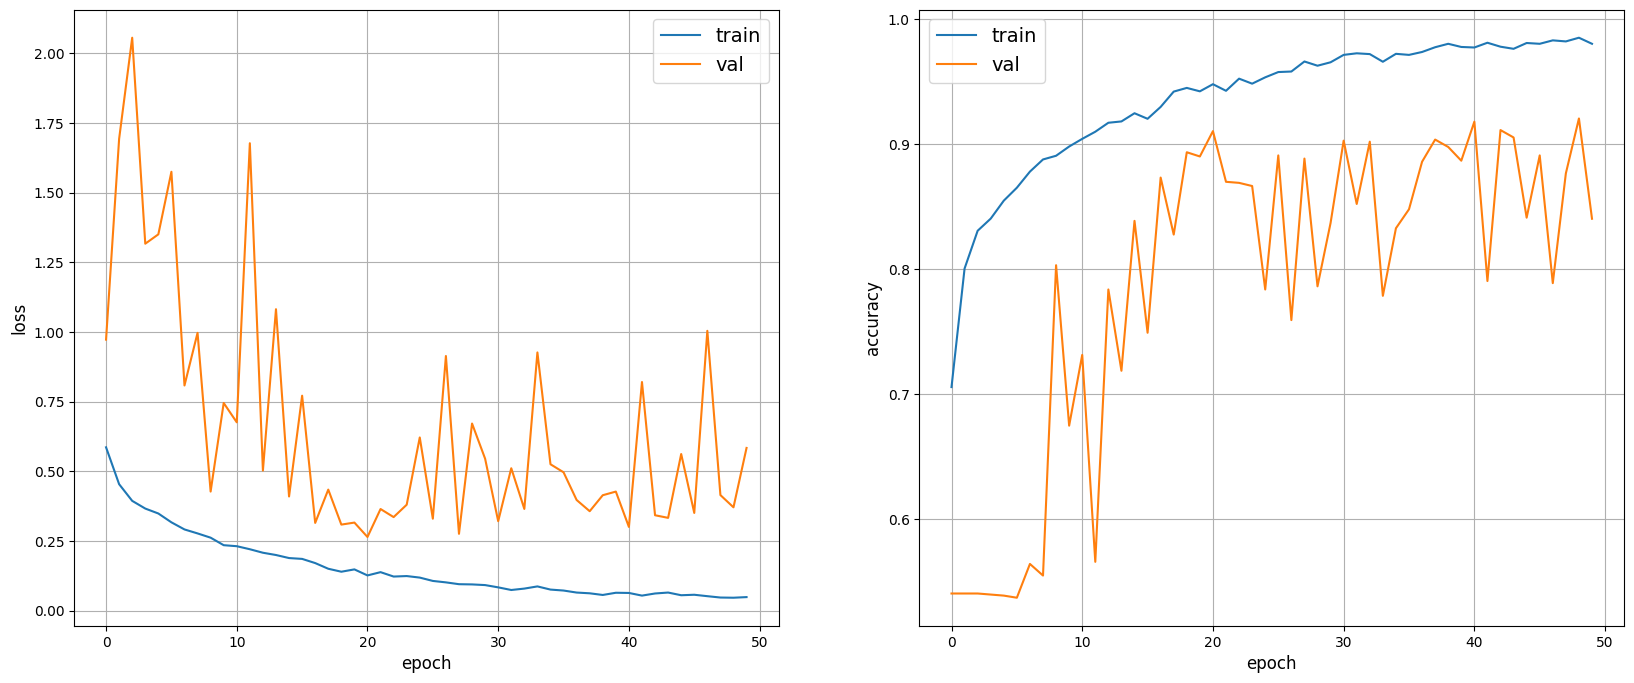

37/37 [==============================] - 0s 5ms/step - loss: 0.5836 - accuracy: 0.8404
Test loss and accuracy: [0.5836453437805176, 0.8403716087341309]


In [ ]:
# Build the classification model
model4_2_last_b_normz = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])


model4_2_last_b_normz.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model4_2_last_b_normz.fit(train_images, train_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model4_2_last_b_normz.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

Epoch 1/50
74/74 [==============================] - 5s 26ms/step - loss: 0.5728 - accuracy: 0.7374 - val_loss: 1.0722 - val_accuracy: 0.5465
Epoch 2/50
74/74 [==============================] - 2s 23ms/step - loss: 0.4280 - accuracy: 0.8113 - val_loss: 1.2775 - val_accuracy: 0.5405
Epoch 3/50
74/74 [==============================] - 2s 22ms/step - loss: 0.3836 - accuracy: 0.8384 - val_loss: 3.1424 - val_accuracy: 0.5405
Epoch 4/50
74/74 [==============================] - 2s 23ms/step - loss: 0.3617 - accuracy: 0.8494 - val_loss: 1.2743 - val_accuracy: 0.5372
Epoch 5/50
74/74 [==============================] - 2s 23ms/step - loss: 0.3067 - accuracy: 0.8739 - val_loss: 2.1349 - val_accuracy: 0.5405
Epoch 6/50
74/74 [==============================] - 2s 23ms/step - loss: 0.2815 - accuracy: 0.8849 - val_loss: 1.8832 - val_accuracy: 0.5380
Epoch 7/50
74/74 [==============================] - 2s 23ms/step - loss: 0.2496 - accuracy: 0.8973 - val_loss: 0.7784 - val_accuracy: 0.6588
Epoch 8/50
74

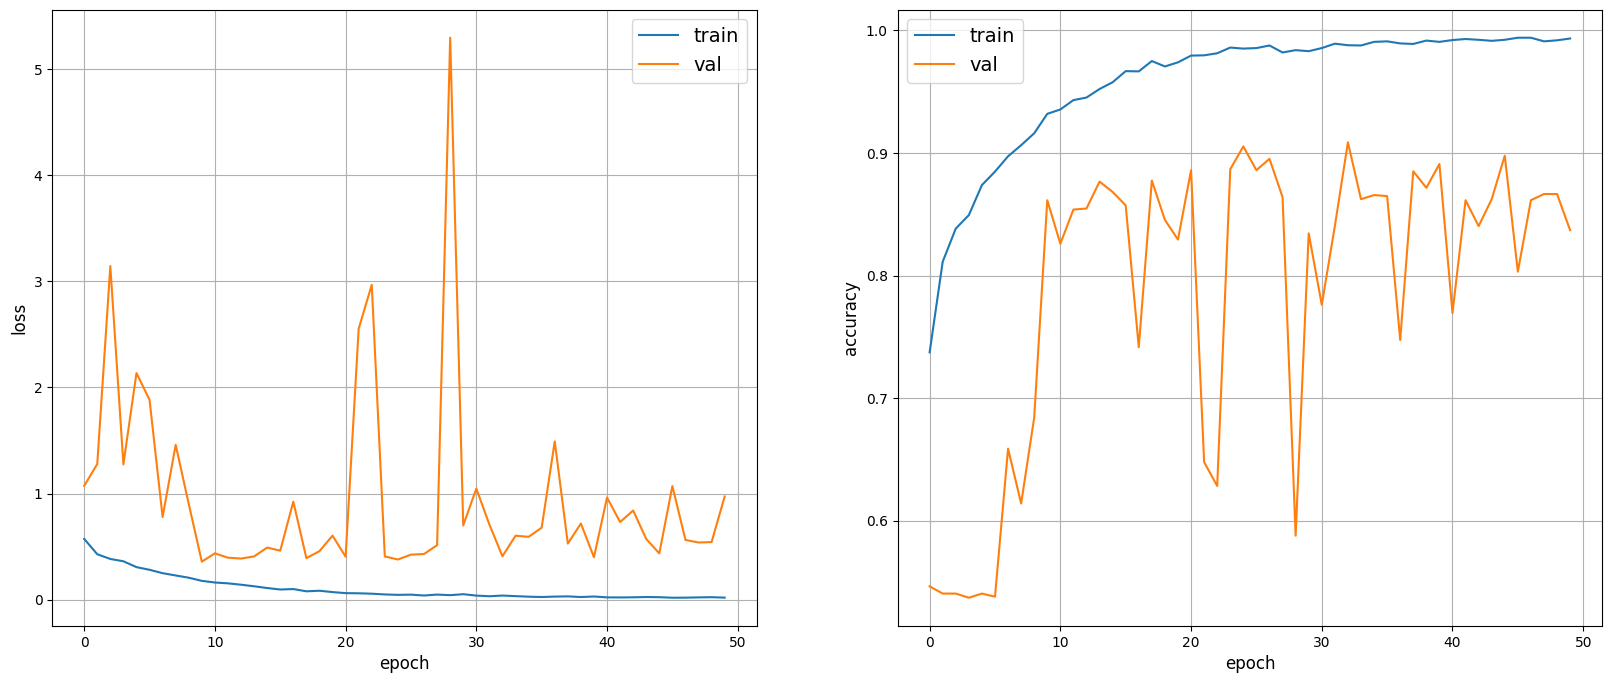

37/37 [==============================] - 0s 5ms/step - loss: 0.9720 - accuracy: 0.8370
Test loss and accuracy: [0.9720363020896912, 0.8369932174682617]


In [ ]:
# Build the classification model
model4_3_last_b_normz = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])


model4_3_last_b_normz.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


history = model4_3_last_b_normz.fit(train_images, train_labels, epochs=EPOCH , batch_size = BATCH,validation_data=(validation_images, validation_labels), callbacks=[callbacks])

plotting_the_result(history)

# Evaluate the model on unseen data
result = model4_3_last_b_normz.evaluate(validation_images, validation_labels)
print(f"Test loss and accuracy:", result)

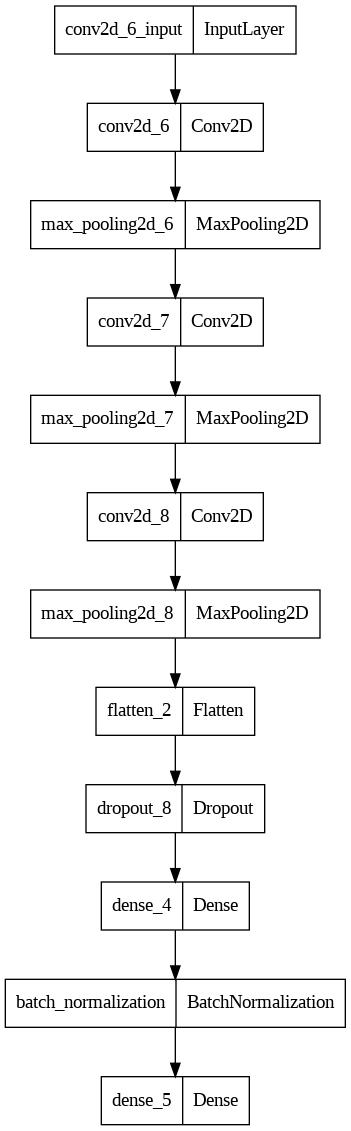

In [ ]:
## THE BEST MODEL
keras.utils.plot_model(model4_last_b_normz, 'model.png')

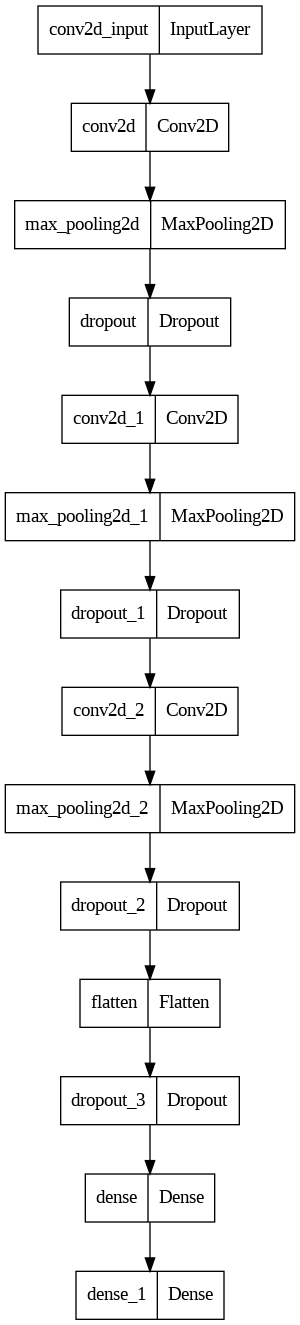

In [ ]:
## THE BEST MODEL
keras.utils.plot_model(model3_all_05, 'model.png')

##5 Fold Cross Validation

In [ ]:

# Creating arrays
images_5_fold = []
labels_5_fold = []

for filename in os.listdir(train_chihuahua_dir):
    img = Image.open(os.path.join(train_chihuahua_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    images_5_fold.append(img_array)
    labels_5_fold.append(0)  # Assign label 0 for chihuahua

for filename in os.listdir(train_muffin_dir):
    img = Image.open(os.path.join(train_muffin_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    images_5_fold.append(img_array)
    labels_5_fold.append(1)  # Assign label 1 for muffin

for filename in os.listdir(validation_chihuahua_dir):
    img = Image.open(os.path.join(validation_chihuahua_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    images_5_fold.append(img_array)
    labels_5_fold.append(0)  # Assign label 0 for chihuahua

for filename in os.listdir(validation_muffin_dir):
    img = Image.open(os.path.join(validation_muffin_dir, filename)).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize the image to (150, 150)
    img_array = np.array(img)
    images_5_fold.append(img_array)
    labels_5_fold.append(1)  # Assign label 1 for muffin

images_5_fold = np.array(images_5_fold)
labels_5_fold = np.array(labels_5_fold)

In [ ]:
#checking arrays
print(len(images_5_fold))
print(len(labels_5_fold))
print(len(labels_5_fold)/5)

5917
5917
1183.4


In [ ]:
import numpy as np

# Assuming you have your data as a numpy array, e.g., data

# Split the data into 5 different arrays
num_folds = 5
fold_size = len(images_5_fold) // num_folds

array1 = images_5_fold[:fold_size]
array2 = images_5_fold[fold_size:2 * fold_size]
array3 = images_5_fold[2 * fold_size:3 * fold_size]
array4 = images_5_fold[3 * fold_size:4 * fold_size]
array5 = images_5_fold[4 * fold_size:]

combination1_tr_img = np.concatenate([array1, array2, array3, array4])
combination2_tr_img = np.concatenate([array2, array3, array4, array5])
combination3_tr_img = np.concatenate([array3, array4, array5, array1])
combination4_tr_img = np.concatenate([array4, array5, array1, array2])
combination5_tr_img = np.concatenate([array5, array1, array2, array3])


combination1_val_img = np.concatenate([array5])
combination2_val_img = np.concatenate([array1])
combination3_val_img = np.concatenate([array2])
combination4_val_img = np.concatenate([array3])
combination5_val_img = np.concatenate([array4])

In [ ]:
print(len(combination1_tr_img))
print(len(combination2_tr_img))
print(len(combination3_tr_img))
print(len(combination4_tr_img))
print(len(combination5_tr_img))

4732
4734
4734
4734
4734


In [ ]:

array1_labels = labels_5_fold[:fold_size]
array2_labels = labels_5_fold[fold_size:2 * fold_size]
array3_labels = labels_5_fold[2 * fold_size:3 * fold_size]
array4_labels = labels_5_fold[3 * fold_size:4 * fold_size]
array5_labels = labels_5_fold[4 * fold_size:]

# Create the combinations as you described
combination1_tr_labels = np.concatenate([array1_labels, array2_labels, array3_labels, array4_labels])
combination2_tr_labels = np.concatenate([array2_labels, array3_labels, array4_labels, array5_labels])
combination3_tr_labels = np.concatenate([array3_labels, array4_labels, array5_labels, array1_labels])
combination4_tr_labels = np.concatenate([array4_labels, array5_labels, array1_labels, array2_labels])
combination5_tr_labels = np.concatenate([array5_labels, array1_labels, array2_labels, array3_labels])


combination1_val_labels = np.concatenate([array5_labels])
combination2_val_labels = np.concatenate([array1_labels])
combination3_val_labels = np.concatenate([array2_labels])
combination4_val_labels = np.concatenate([array3_labels])
combination5_val_labels = np.concatenate([array4_labels])

In [ ]:
#resizing and converting to tensors


combination1_tr_img = combination1_tr_img / 255.0
combination2_tr_img = combination2_tr_img / 255.0
combination3_tr_img = combination3_tr_img / 255.0
combination4_tr_img = combination4_tr_img / 255.0
combination5_tr_img = combination5_tr_img / 255.0

combination1_val_img = combination1_val_img/ 255.0
combination2_val_img = combination2_val_img/ 255.0
combination3_val_img = combination3_val_img/ 255.0
combination4_val_img = combination4_val_img/ 255.0
combination5_val_img = combination5_val_img/ 255.0


combination1_tr_img = tf.convert_to_tensor(combination1_tr_img)
combination2_tr_img = tf.convert_to_tensor(combination2_tr_img)
combination3_tr_img = tf.convert_to_tensor(combination3_tr_img)
combination4_tr_img = tf.convert_to_tensor(combination4_tr_img)
combination5_tr_img = tf.convert_to_tensor(combination5_tr_img)

combination1_val_img = tf.convert_to_tensor(combination1_val_img)
combination2_val_img = tf.convert_to_tensor(combination2_val_img)
combination3_val_img = tf.convert_to_tensor(combination3_val_img)
combination4_val_img = tf.convert_to_tensor(combination4_val_img)
combination5_val_img = tf.convert_to_tensor(combination5_val_img)



In [ ]:
#labels
#converting to tensors
size1_t = combination1_tr_img.shape[0]
size2_t = combination2_tr_img.shape[0]
size3_t = combination3_tr_img.shape[0]
size4_t = combination4_tr_img.shape[0]
size5_t = combination5_tr_img.shape[0]


size1_v = combination1_val_img.shape[0]
size2_v = combination2_val_img.shape[0]
size3_v = combination3_val_img.shape[0]
size4_v = combination4_val_img.shape[0]
size5_v = combination5_val_img.shape[0]



combination1_tr_labels = tf.reshape(tf.convert_to_tensor(combination1_tr_labels, dtype=tf.float32), shape = [size1_t, 1])
combination2_tr_labels = tf.reshape(tf.convert_to_tensor(combination2_tr_labels, dtype=tf.float32), shape = [size2_t, 1])
combination3_tr_labels = tf.reshape(tf.convert_to_tensor(combination3_tr_labels, dtype=tf.float32), shape = [size3_t, 1])
combination4_tr_labels = tf.reshape(tf.convert_to_tensor(combination4_tr_labels, dtype=tf.float32), shape = [size4_t, 1])
combination5_tr_labels = tf.reshape(tf.convert_to_tensor(combination5_tr_labels, dtype=tf.float32), shape = [size5_t, 1])

combination1_val_labels = tf.reshape(tf.convert_to_tensor(combination1_val_labels, dtype=tf.float32), shape = [size1_v, 1])
combination2_val_labels = tf.reshape(tf.convert_to_tensor(combination2_val_labels, dtype=tf.float32), shape = [size2_v, 1])
combination3_val_labels = tf.reshape(tf.convert_to_tensor(combination3_val_labels, dtype=tf.float32), shape = [size3_v, 1])
combination4_val_labels = tf.reshape(tf.convert_to_tensor(combination4_val_labels, dtype=tf.float32), shape = [size4_v, 1])
combination5_val_labels = tf.reshape(tf.convert_to_tensor(combination5_val_labels, dtype=tf.float32), shape = [size5_v, 1])

### Model3_all_05

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix

In [61]:
EPOCH = 20 #For optimisation

In [62]:
BATCH = 64

In [63]:
#Add the breaker after the accuracy 1.0 on training set

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') >= 1.000):

      # Stop if threshold is met
      print("\Accuracy is equal 1.000 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [64]:
# Build the classification model
#1 model
model3_all_051 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_051.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


#2 model
model3_all_052 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_052.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


#3 model
model3_all_053 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_053.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#4 model
model3_all_054 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_054.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#5 model
model3_all_055 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model3_all_055.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


In [66]:
fold1_model3_all_051 = model3_all_051.fit(combination1_tr_img, combination1_tr_labels, epochs=EPOCH,validation_data=(combination1_val_img, combination1_val_labels), callbacks=[callbacks] )


Epoch 1/20
148/148 [==============================] - 32s 209ms/step - loss: 0.7540 - accuracy: 0.5594 - val_loss: 0.6688 - val_accuracy: 0.6650
Epoch 2/20
148/148 [==============================] - 31s 206ms/step - loss: 0.5982 - accuracy: 0.6872 - val_loss: 0.5284 - val_accuracy: 0.7376
Epoch 3/20
148/148 [==============================] - 30s 206ms/step - loss: 0.5233 - accuracy: 0.7525 - val_loss: 0.4895 - val_accuracy: 0.7907
Epoch 4/20
148/148 [==============================] - 31s 211ms/step - loss: 0.4921 - accuracy: 0.7724 - val_loss: 0.4563 - val_accuracy: 0.8101
Epoch 5/20
148/148 [==============================] - 30s 206ms/step - loss: 0.4524 - accuracy: 0.7984 - val_loss: 0.6065 - val_accuracy: 0.6878
Epoch 6/20
148/148 [==============================] - 30s 204ms/step - loss: 0.4356 - accuracy: 0.8098 - val_loss: 0.4216 - val_accuracy: 0.8236
Epoch 7/20
148/148 [==============================] - 30s 205ms/step - loss: 0.4155 - accuracy: 0.8134 - val_loss: 0.3890 - val_ac

In [68]:
fold2_model3_all_05 = model3_all_052.fit(combination2_tr_img, combination2_tr_labels, epochs=EPOCH ,validation_data=(combination2_val_img, combination2_val_labels), callbacks=[callbacks])
fold3_model3_all_05 = model3_all_053.fit(combination3_tr_img, combination3_tr_labels, epochs=EPOCH ,validation_data=(combination3_val_img, combination3_val_labels), callbacks=[callbacks])
fold4_model3_all_05 = model3_all_054.fit(combination4_tr_img, combination4_tr_labels, epochs=EPOCH ,validation_data=(combination4_val_img, combination4_val_labels), callbacks=[callbacks])
fold5_model3_all_05 = model3_all_055.fit(combination5_tr_img, combination5_tr_labels, epochs=EPOCH ,validation_data=(combination5_val_img, combination5_val_labels), callbacks=[callbacks])


Epoch 1/20
148/148 [==============================] - 32s 207ms/step - loss: 0.7709 - accuracy: 0.5917 - val_loss: 0.7097 - val_accuracy: 0.5402
Epoch 2/20
148/148 [==============================] - 30s 202ms/step - loss: 0.5536 - accuracy: 0.7302 - val_loss: 0.3164 - val_accuracy: 0.9298
Epoch 3/20
148/148 [==============================] - 30s 200ms/step - loss: 0.4969 - accuracy: 0.7719 - val_loss: 0.6574 - val_accuracy: 0.6720
Epoch 4/20
148/148 [==============================] - 30s 201ms/step - loss: 0.4662 - accuracy: 0.7850 - val_loss: 0.3256 - val_accuracy: 0.9036
Epoch 5/20
148/148 [==============================] - 30s 203ms/step - loss: 0.4407 - accuracy: 0.8004 - val_loss: 0.4447 - val_accuracy: 0.8174
Epoch 6/20
148/148 [==============================] - 30s 201ms/step - loss: 0.4179 - accuracy: 0.8139 - val_loss: 0.4232 - val_accuracy: 0.8326
Epoch 7/20
148/148 [==============================] - 30s 204ms/step - loss: 0.3888 - accuracy: 0.8295 - val_loss: 0.1686 - val_ac

In [67]:
#predicting and rounding to 0 and 1, computing the zero-one loss

y_predictions_1_fold = model3_all_051.predict(combination1_val_img)
y_predictions_1_fold_np = tf.round(y_predictions_1_fold).numpy()
y_validation_1_fold_np = combination1_val_labels.numpy() #true labels
#results

print(accuracy_score(y_validation_1_fold_np, y_predictions_1_fold_np))
print(zero_one_loss(y_validation_1_fold_np, y_predictions_1_fold_np))

38/38 [==============================] - 2s 41ms/step
0.8548523206751055
0.14514767932489447


In [69]:
y_predictions_2_fold = model3_all_052.predict(combination2_val_img)
y_predictions_3_fold = model3_all_053.predict(combination3_val_img)
y_predictions_4_fold = model3_all_054.predict(combination4_val_img)
y_predictions_5_fold = model3_all_055.predict(combination5_val_img)


y_predictions_2_fold_np = tf.round(y_predictions_2_fold).numpy()
y_predictions_3_fold_np = tf.round(y_predictions_3_fold).numpy()
y_predictions_4_fold_np = tf.round(y_predictions_4_fold).numpy()
y_predictions_5_fold_np = tf.round(y_predictions_5_fold).numpy()



37/37 [==============================] - 2s 40ms/step


In [70]:
y_validation_2_fold_np = combination2_val_labels.numpy() #true labels
y_validation_3_fold_np = combination3_val_labels.numpy() #true labels
y_validation_4_fold_np = combination4_val_labels.numpy() #true labels
y_validation_5_fold_np = combination5_val_labels.numpy() #true labels

In [71]:
model_validation_accuracy_model3_all_05 = []
model_zero_one_loss_model3_all_05 = []


In [73]:
model_validation_accuracy_model3_all_05.append(accuracy_score(y_validation_1_fold_np, y_predictions_1_fold_np))
model_validation_accuracy_model3_all_05.append(accuracy_score(y_validation_2_fold_np, y_predictions_2_fold_np))
model_validation_accuracy_model3_all_05.append(accuracy_score(y_validation_3_fold_np, y_predictions_3_fold_np))
model_validation_accuracy_model3_all_05.append(accuracy_score(y_validation_4_fold_np, y_predictions_4_fold_np))
model_validation_accuracy_model3_all_05.append(accuracy_score(y_validation_5_fold_np, y_predictions_5_fold_np))


In [74]:
model_zero_one_loss_model3_all_05.append(zero_one_loss(y_validation_1_fold_np, y_predictions_1_fold_np))
model_zero_one_loss_model3_all_05.append(zero_one_loss(y_validation_2_fold_np, y_predictions_2_fold_np))
model_zero_one_loss_model3_all_05.append(zero_one_loss(y_validation_3_fold_np, y_predictions_3_fold_np))
model_zero_one_loss_model3_all_05.append(zero_one_loss(y_validation_4_fold_np, y_predictions_4_fold_np))
model_zero_one_loss_model3_all_05.append(zero_one_loss(y_validation_5_fold_np, y_predictions_5_fold_np))


In [75]:
print(f'Accuracy: {np.mean(model_validation_accuracy_model3_all_05)} (+- {np.std(model_validation_accuracy_model3_all_05)})')
print(f'Zero-one Loss: {np.mean(model_zero_one_loss_model3_all_05)}')

Accuracy: 0.8140811995534488 (+- 0.1045602144861959)
Zero-one Loss: 0.18591880044655115


### Model4_last_b_normz

In [76]:
# Build the classification model
model4_last_b_normz1 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz1.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#2

# Build the classification model
model4_last_b_normz2 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz2.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


#3

# Build the classification model
model4_last_b_normz3 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz3.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#4

# Build the classification model
model4_last_b_normz4 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz4.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#5

# Build the classification model
model4_last_b_normz5 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(150, 150,1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation= 'sigmoid')])

model4_last_b_normz5.compile(optimizer = "rmsprop" ,#tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])



In [77]:
fold1_model4_last_b_normz = model4_last_b_normz1.fit(combination1_tr_img, combination1_tr_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(combination1_val_img, combination1_val_labels), callbacks=[callbacks])
fold2_model4_last_b_normz = model4_last_b_normz2.fit(combination2_tr_img, combination2_tr_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(combination2_val_img, combination2_val_labels), callbacks=[callbacks])
fold3_model4_last_b_normz = model4_last_b_normz3.fit(combination3_tr_img, combination3_tr_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(combination3_val_img, combination3_val_labels), callbacks=[callbacks])
fold4_model4_last_b_normz = model4_last_b_normz4.fit(combination4_tr_img, combination4_tr_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(combination4_val_img, combination4_val_labels), callbacks=[callbacks])
fold5_model4_last_b_normz = model4_last_b_normz5.fit(combination5_tr_img, combination5_tr_labels, epochs=EPOCH, batch_size = BATCH ,validation_data=(combination5_val_img, combination5_val_labels), callbacks=[callbacks])


Epoch 1/20
74/74 [==============================] - 29s 383ms/step - loss: 0.5603 - accuracy: 0.7253 - val_loss: 0.5586 - val_accuracy: 0.7409
Epoch 2/20
74/74 [==============================] - 28s 373ms/step - loss: 0.4344 - accuracy: 0.8064 - val_loss: 0.9856 - val_accuracy: 0.5865
Epoch 3/20
74/74 [==============================] - 28s 373ms/step - loss: 0.3702 - accuracy: 0.8407 - val_loss: 0.4876 - val_accuracy: 0.7629
Epoch 4/20
74/74 [==============================] - 28s 377ms/step - loss: 0.3163 - accuracy: 0.8664 - val_loss: 0.5406 - val_accuracy: 0.7586
Epoch 5/20
74/74 [==============================] - 29s 386ms/step - loss: 0.2632 - accuracy: 0.8918 - val_loss: 0.3303 - val_accuracy: 0.8616
Epoch 6/20
74/74 [==============================] - 28s 376ms/step - loss: 0.2205 - accuracy: 0.9093 - val_loss: 0.4237 - val_accuracy: 0.8321
Epoch 7/20
74/74 [==============================] - 27s 371ms/step - loss: 0.2004 - accuracy: 0.9210 - val_loss: 0.3212 - val_accuracy: 0.8751

In [81]:
y_predictions_1_fold2 = model4_last_b_normz1.predict(combination1_val_img)
y_predictions_2_fold2 = model4_last_b_normz2.predict(combination2_val_img)
y_predictions_3_fold2 = model4_last_b_normz3.predict(combination3_val_img)
y_predictions_4_fold2 = model4_last_b_normz4.predict(combination4_val_img)
y_predictions_5_fold2 = model4_last_b_normz5.predict(combination5_val_img)


y_predictions_1_fold_np2 = tf.round(y_predictions_1_fold2).numpy()
y_predictions_2_fold_np2 = tf.round(y_predictions_2_fold2).numpy()
y_predictions_3_fold_np2 = tf.round(y_predictions_3_fold2).numpy()
y_predictions_4_fold_np2 = tf.round(y_predictions_4_fold2).numpy()
y_predictions_5_fold_np2 = tf.round(y_predictions_5_fold2).numpy()



37/37 [==============================] - 2s 41ms/step


In [82]:
model_validation_accuracy_model4_last_b_normz = []
model_zero_one_loss_model4_last_b_normz = []


In [83]:
model_validation_accuracy_model4_last_b_normz.append(accuracy_score(y_validation_1_fold_np, y_predictions_1_fold_np2))
model_validation_accuracy_model4_last_b_normz.append(accuracy_score(y_validation_2_fold_np, y_predictions_2_fold_np2))
model_validation_accuracy_model4_last_b_normz.append(accuracy_score(y_validation_3_fold_np, y_predictions_3_fold_np2))
model_validation_accuracy_model4_last_b_normz.append(accuracy_score(y_validation_4_fold_np, y_predictions_4_fold_np2))
model_validation_accuracy_model4_last_b_normz.append(accuracy_score(y_validation_5_fold_np, y_predictions_5_fold_np2))


In [84]:
model_zero_one_loss_model4_last_b_normz.append(zero_one_loss(y_validation_1_fold_np, y_predictions_1_fold_np2))
model_zero_one_loss_model4_last_b_normz.append(zero_one_loss(y_validation_2_fold_np, y_predictions_2_fold_np2))
model_zero_one_loss_model4_last_b_normz.append(zero_one_loss(y_validation_3_fold_np, y_predictions_3_fold_np2))
model_zero_one_loss_model4_last_b_normz.append(zero_one_loss(y_validation_4_fold_np, y_predictions_4_fold_np2))
model_zero_one_loss_model4_last_b_normz.append(zero_one_loss(y_validation_5_fold_np, y_predictions_5_fold_np2))


In [85]:
print(f'Accuracy: {np.mean(model_validation_accuracy_model4_last_b_normz)} (+- {np.std(model_validation_accuracy_model4_last_b_normz)})')
print(f'Zero-one Loss: {np.mean(model_zero_one_loss_model4_last_b_normz)}')

Accuracy: 0.833676949470523 (+- 0.037389438058469796)
Zero-one Loss: 0.16632305052947702
